In [2]:
import pandas as pd
import numpy as np
import sqlite3
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DB_PATH = "data/parsed_data.db"

# Подключение к базе
conn = sqlite3.connect(DB_PATH)

# Чтение таблицы Users
df_users = pd.read_sql_query("SELECT * FROM Users", conn)

# Чтение таблицы Ratings
df_ratings = pd.read_sql_query("SELECT * FROM Ratings", conn)

# Закрываем соединение
conn.close()


In [3]:
df_ratings.tail()

,user,liked,film,reviewed,rating
12790633,cinemelis,0,bellissima,0,7
12790634,cinemelis,0,sunset-boulevard,0,9
12790635,cinemelis,0,citizen-kane,0,6
12790636,cinemelis,0,dracula,0,8
12790637,cinemelis,0,battleship-potemkin,0,7


## Utils functions

In [190]:
def cnt_nan_feature(df, feature_name):
    print("Count of Nan: {} objects \n{}% in dataset".format(df[feature_name].isna().sum(), round(df[feature_name].isna().sum()/df.shape[0]*100, 2)))

def cnt_empty_list_feature(df, feature_name):
    tmp = df[df[feature_name].apply(lambda x: len(x) == 0)]["name"].count()
    print("Count of empty lists: {} objects \n{}% in dataset".format(tmp, round(tmp/df.shape[0]*100, 2)))

In [235]:
def value_intersaction_on_set_feature(df: pd.DataFrame, feature: str, df_films: pd.DataFrame) -> pd.DataFrame: 
    """df - already exploded dataframe"""
    df_exp = df[[feature, "name"]]
    df_exp = df_exp.dropna()
    df_pairs = df_exp.merge(df_exp, on="name")
    df_pairs[f'{feature}_1'] = df_pairs[[f'{feature}_x', f'{feature}_y']].min(axis=1)
    df_pairs[f'{feature}_2'] = df_pairs[[f'{feature}_x', f'{feature}_y']].max(axis=1)
    df_pairs = df_pairs[df_pairs[f"{feature}_x"] != df_pairs[f"{feature}_y"]]
    df_pairs = df_pairs.merge(df_films[["name", "watched", "rating", "year"]], on="name")
    df_pairs = df_pairs.drop(columns=[f"{feature}_x", f"{feature}_y"])
    df_pairs = df_pairs.drop_duplicates()
    return df_pairs

In [5]:
def get_crew_member_df(df, crew_position):
    result = df.groupby(by=crew_position).agg({"watched": "mean", "name": "count", "year": ["max", "min"], "rating":"mean"})
    result.columns = ['watched_mean', 'count_films', 'last_film', 'debute', 'mean_rating']
    #Add most_popular film, debute_rating, career_span, grouping by decades
    return result

In [6]:
def get_crew_duets(df, crew_position1, crew_position2):
    df_clean = df.dropna(subset=[crew_position1, crew_position2, "watched"])
    df1 = df_clean.groupby(by=[crew_position1, crew_position2]).agg({"name": "count", "rating": ["mean", "max"], "watched": ["mean", "max"], "year": ["max", "min"]}).reset_index()
    popular_films_idx = df_clean.groupby(by=[crew_position1, crew_position2])["watched"].idxmax()
    df2 = df_clean.loc[popular_films_idx, [crew_position1, crew_position2, "name"]].rename(columns={"name": "most_popular_film"}).reset_index(drop=True)
    df1.columns = [crew_position1, crew_position2, "count_films", "rating_mean", "rating_max", "watched_mean", "watched_max", "year_max", "year_min"]
    result = pd.merge(df1, df2, on=[crew_position1, crew_position2], how="left")
    result = result[result["count_films"] >= 3]
    return result

# Films

In [ ]:
films = []
for i in range(1, 72):
    with open(f"data/lb_films/parsed_films_checkpoint{i}.json", "r") as f:
        films1 = json.loads(f.read())
    films.extend(films1)
print(len(films))

35500


In [4]:
df_films = pd.DataFrame(films)

In [5]:
df_films.shape

(35500, 31)

In [6]:
pd.set_option('display.max_columns', 31)

In [7]:
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,liked,top,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link
0,Barbie,2023.0,Barbie and Ken are having the time of their li...,19815.0,46092.0,29452.0,156921.0,151069.0,629766.0,556874.0,1146076.0,409547.0,944956.0,7.72,5.2M,2.1M,None,"[s(he's) bro(ken), can someone please check on...",She’s everything. He’s just Ken.,114.0,"[Margot Robbie, Ryan Gosling, America Ferrera,...",Greta Gerwig,Noah Baumbach,Robbie Brenner,Rodrigo Prieto,Andrew Wyatt,"[LuckyChap Entertainment, Heyday Films, NB/GG ...","[UK, USA]","[Comedy, Adventure]","[Humanity and the world around us, Crude humor...",https://letterboxd.com/film/barbie/
1,Parasite,2019.0,"All unemployed, Ki-taek’s family takes peculia...",3323.0,7856.0,3359.0,22721.0,18912.0,133783.0,155354.0,801802.0,642917.0,2010232.0,9.05,5M,2.7M,9,[Update: Now in video formThere is a house on ...,Act like you own the place.,133.0,"[Song Kang-ho, Lee Sun-kyun, Cho Yeo-jeong, Ch...",Bong Joon Ho,Kim Dae-hwan,Jang Young-hwan,Hong Kyung-pyo,Jung Jae-il,[Barunson E&A],[South Korea],"[Comedy, Thriller, Drama]","[Humanity and the world around us, Intense vio...",https://letterboxd.com/film/parasite-2019/
2,Interstellar,2014.0,The adventures of a group of explorers who mak...,5543.0,14091.0,7183.0,46427.0,36925.0,204718.0,203485.0,728838.0,530882.0,1922478.0,8.89,5M,2.4M,52,[tell me you wouldn't cry too if your son grow...,Mankind was born on Earth. It was never meant ...,169.0,"[Matthew McConaughey, Anne Hathaway, Michael C...",Christopher Nolan,Jonathan Nolan,Lynda Obst,Hoyte van Hoytema,Hans Zimmer,"[Legendary Pictures, Syncopy, Lynda Obst Produ...","[UK, USA]","[Science Fiction, Drama, Adventure]","[Monsters, aliens, sci-fi and the apocalypse, ...",https://letterboxd.com/film/interstellar/
3,Fight Club,1999.0,A ticking-time-bomb insomniac and a slippery s...,5027.0,13309.0,6685.0,44141.0,37583.0,244093.0,263380.0,1000560.0,572952.0,1393347.0,8.61,5.1M,2.3M,181,[first watch: fight club is the best movie eve...,Mischief. Mayhem. Soap.,139.0,"[Edward Norton, Brad Pitt, Helena Bonham Carte...",David Fincher,Jim Uhls,Art Linson,Jeff Cronenweth,John King,"[Fox 2000 Pictures, Regency Enterprises, Linso...","[Germany, USA]",[Drama],"[Intense violence and sexual transgression, Hu...",https://letterboxd.com/film/fight-club/
4,La La Land,2016.0,"Mia, an aspiring actress, serves lattes to mov...",14471.0,44167.0,15291.0,106473.0,61872.0,318154.0,247374.0,760376.0,404405.0,1247646.0,8.30,4.4M,2M,None,[this cured my depression and brought it back ...,Here’s to the fools who dream.,129.0,"[Ryan Gosling, Emma Stone, John Legend, Rosema...",Damien Chazelle,Damien Chazelle,Jordan Horowitz,Linus Sandgren,Justin Hurwitz,"[Summit Entertainment, Gilbert Films, Impostor...",[USA],"[Drama, Comedy, Music, Romance]","[Song and dance, Humanity and the world around...",https://letterboxd.com/film/la-la-land/


Films are sorted by popularity

In [12]:
df_films = df_films.sample(frac=1)

In [13]:
df_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35500 entries, 2481 to 17117
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             35489 non-null  object 
 1   year             35371 non-null  float64
 2   description      35470 non-null  object 
 3   1                33417 non-null  float64
 4   2                33417 non-null  float64
 5   3                33417 non-null  float64
 6   4                33417 non-null  float64
 7   5                33417 non-null  float64
 8   6                33417 non-null  float64
 9   7                33417 non-null  float64
 10  8                33413 non-null  float64
 11  9                33380 non-null  float64
 12  10               32906 non-null  float64
 13  rating           33417 non-null  float64
 14  watched          33486 non-null  object 
 15  liked            33486 non-null  object 
 16  top              249 non-null    object 
 17  popular_review

In [14]:
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,liked,top,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link
2481,The Taking of Deborah Logan,2014.0,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,6.22,160K,29K,None,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...
15396,Phantom of the Megaplex,2000.0,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,5.55,20K,2.4K,None,"[Mickey Rooney as Movie Mason and his ""Magic a...",None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...
26010,Creating Rem Lezar,1989.0,Zack and Ashlee discover the meaning of true f...,269.0,248.0,129.0,183.0,105.0,226.0,93.0,157.0,60.0,536.0,5.77,3.2K,1.2K,None,[My favorite part was when they questioned the...,Every Child has a Rem Lezar.,48.0,"[Jack Mulcahy, Courtney Kernaghan, Jonathan Go...",Scott Zakarin,Scott Zakarin,None,Richard E. Brooks,Mark Mulé,[JSL Video Services Inc.],[USA],"[Fantasy, Music, Family]",[],https://letterboxd.com/film/creating-rem-lezar/
32795,The Yellow Mercedes,1993.0,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,7.47,3.8K,638,None,"[Bayram, hangi yönü seçeceğini bilmeden, dörty...",None,90.0,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Switzerland, Turkey, France, Germany]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/
19980,Love & Human Remains,1993.0,"In a Canadian metropolis, failed actor David s...",7.0,28.0,38.0,151.0,203.0,551.0,556.0,532.0,178.0,289.0,7.00,3.5K,1.2K,None,"[honey I'm homo, I like to imagine this as hot...",Welcome to love in the 90’s,100.0,"[Thomas Gibson, Ruth Marshall, Cameron Bancrof...",Denys Arcand,Brad Fraser,Roger Frappier,Paul Sarossy,John McCarthy,"[Atlantis Films, First Choice Films, The Ontar...",[Canada],"[Drama, Comedy]",[],https://letterboxd.com/film/love-human-remains/


## First data preparation

In [15]:
def convert_watched(value):
    if isinstance(value, str):
        if "K" in value:
            return float(value.replace("K", "")) * 1e3
        elif "M" in value:
            return float(value.replace("M", "")) * 1e6
        else:
            return float(value)
    return value

df_films["watched"] = df_films["watched"].map(convert_watched)
df_films["liked"] = df_films["liked"].map(convert_watched)

## Features

### Year

In [16]:
print("Count of Nan: {} objects \n{}% in dataset".format(df_films["year"].isna().sum(), round(df_films["year"].isna().sum()/df_films.shape[0]*100, 2)))

Count of Nan: 129 objects 
0.36% in dataset


In [17]:
round(df_films["year"].isna().sum()/df_films["year"].count()*100, 4), df_films["year"].isna().sum()

(np.float64(0.3647), np.int64(129))

In [18]:
df_films[df_films["year"].isna()]["watched"].mean(), df_films[df_films["year"].notna()]["watched"].mean()

(np.float64(703.1020408163265), np.float64(72755.1212411645))

In [19]:
df_films[df_films["year"].isna()]["watched"].min(), df_films[df_films["year"].isna()]["watched"].max()

(np.float64(18.0), np.float64(21000.0))

We can easily drop all nulls from dataset - all such flims has small count of viewers

In [20]:
df_films = df_films.dropna(subset=["year"])
df_films["year"] = df_films["year"].astype(np.int32)

In [21]:
df_films["year"]

2481     2014
15396    2000
26010    1989
32795    1993
19980    1993
         ... 
22482    2017
34185    2016
21780    2007
34700    1995
17117    2020
Name: year, Length: 35371, dtype: int32

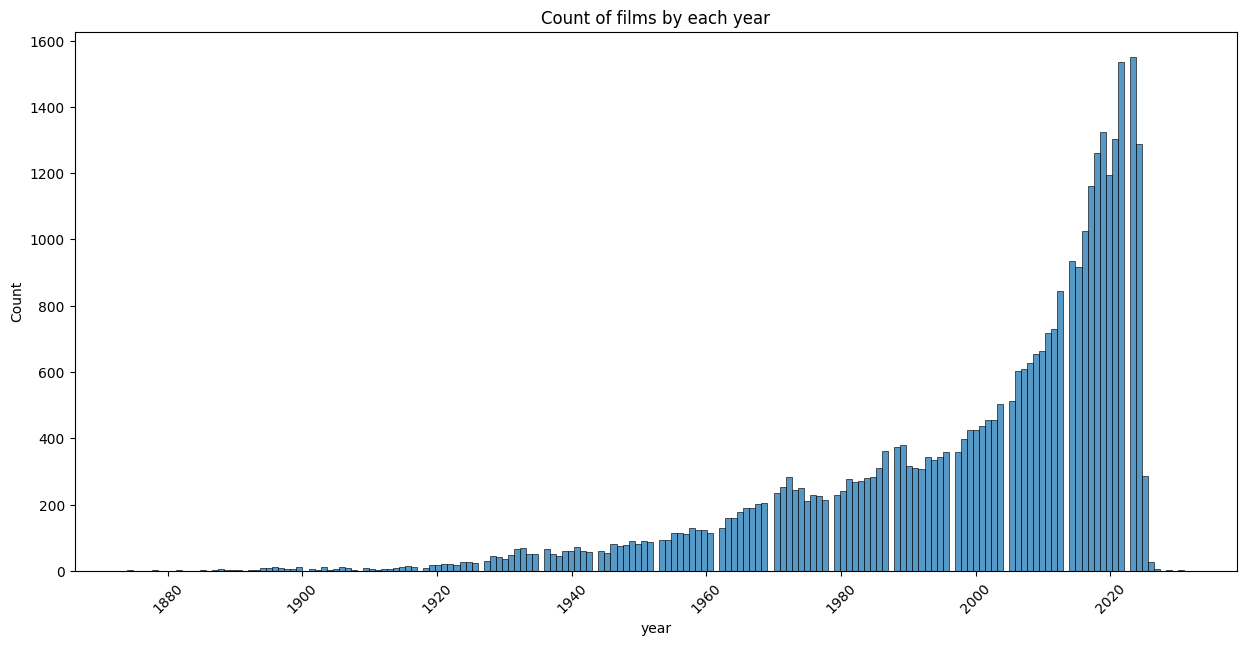

In [22]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films, x="year", bins=175)
plt.xticks(rotation=45)
plt.title("Count of films by each year")
plt.show()

In [23]:
df_films[df_films["year"] > 2024].shape

(320, 31)

In [24]:
df_films = df_films[df_films["year"] <= 2024]

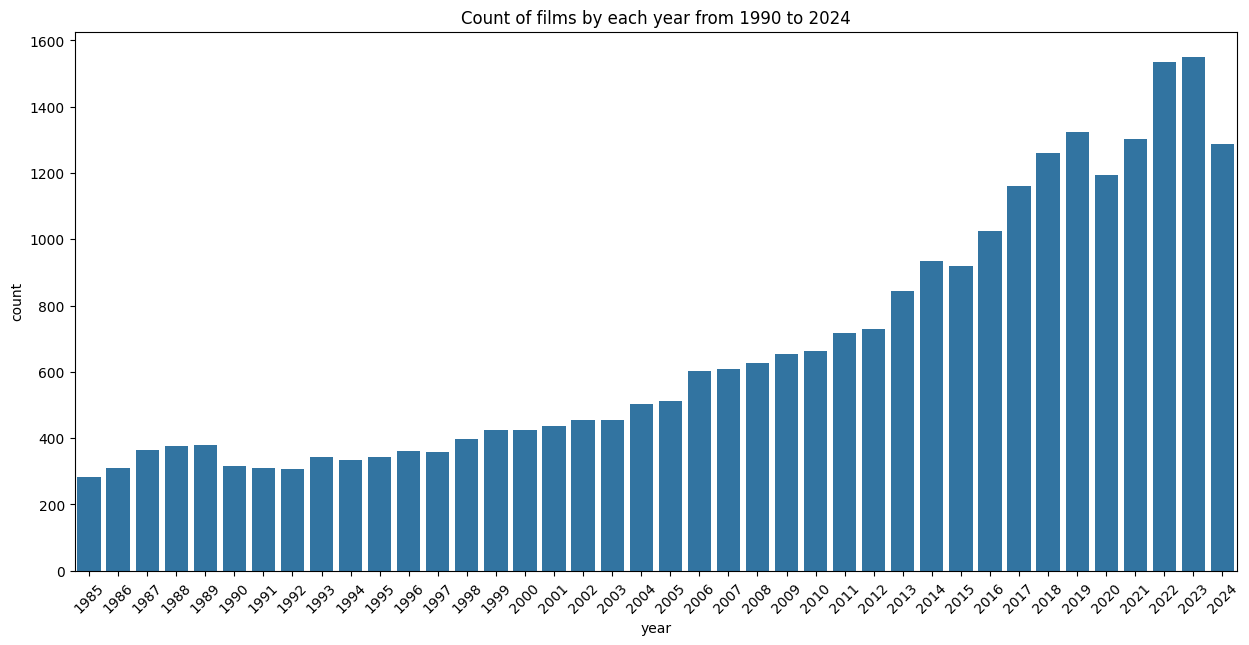

In [25]:
plt.figure(figsize=(15, 7))
sns.countplot(data=df_films[(df_films["year"]>=1985) & (df_films["year"]<2025)], x="year")
plt.xticks(rotation=45)
plt.title("Count of films by each year from 1990 to 2024")
plt.show()

In [26]:
df_films["decade"] = df_films["year"]//10*10

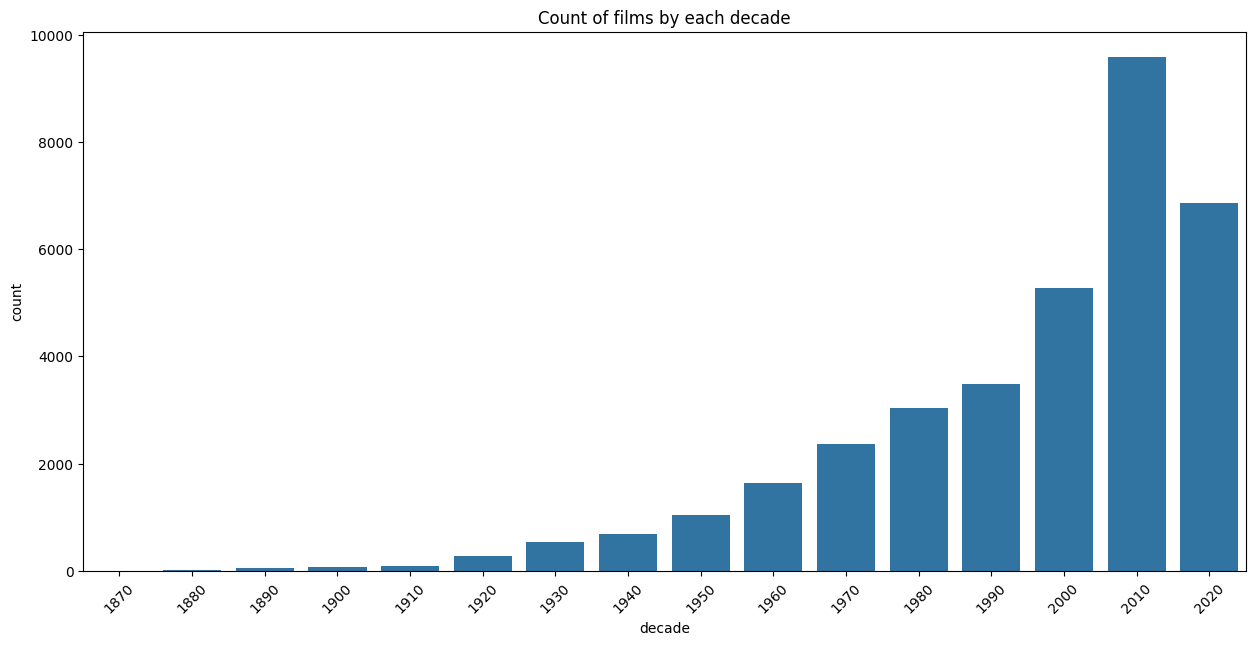

In [27]:
plt.figure(figsize=(15, 7))
sns.countplot(data=df_films, x="decade")
plt.xticks(rotation=45)
plt.title("Count of films by each decade")
plt.show()

In [28]:
df_films.groupby(by="decade")["name"].count()

decade
1870       4
1880       9
1890      53
1900      68
1910      95
1920     276
1930     544
1940     687
1950    1037
1960    1645
1970    2373
1980    3044
1990    3494
2000    5275
2010    9577
2020    6870
Name: name, dtype: int64

Let's drop too old films. As threshold let's take 1920 - only 229 films were directed before 1920

In [29]:
df_films = df_films[df_films["year"] >= 1920]

I've decided to leave "decade" feature as categorical. Maybe it would help to catch more complex dependancy, than linear on year.

TO DO: One-hot encode "decade"

Count of films represented in this dataset increases by next year. New century brings way more flims.

129 films with None were dropped.
Also films were constraint by year - were dropped films shoted before 1920 (229) and after 2024 (320)

### Watched

In [30]:
print("Count of Nan: {} objects \n{}% in dataset".format(df_films["watched"].isna().sum(), round(df_films["watched"].isna().sum()/df_films.shape[0]*100, 2)))

Count of Nan: 1944 objects 
5.58% in dataset


Count of films with Nan in this feature is big, so better to not drop them without trying to reconstruct value. In this dataset are another numeric features like "liked" and ratings from 1 to 10, and them could help us to restore values

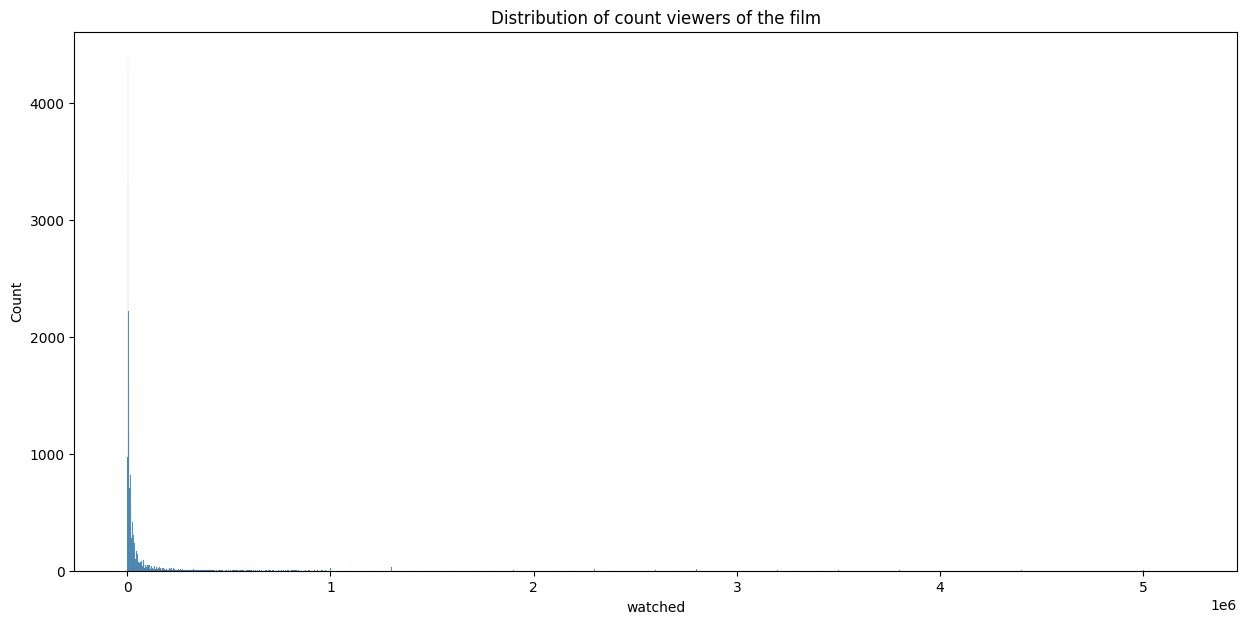

In [31]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films, x="watched")
plt.title("Distribution of count viewers of the film")
plt.show()

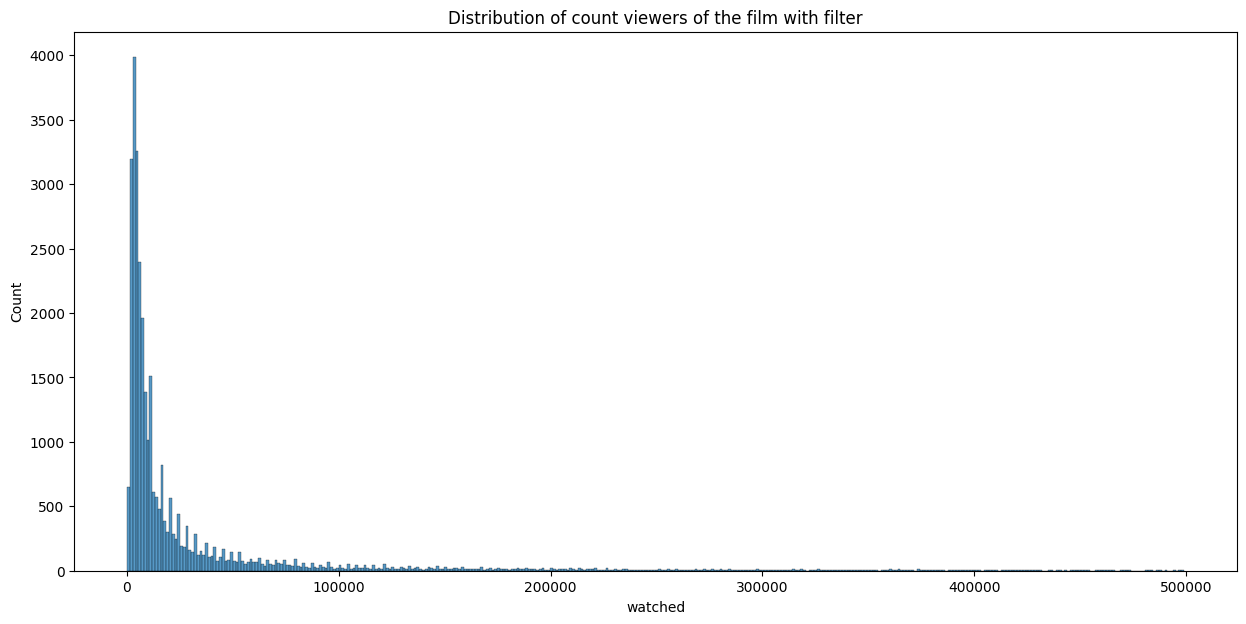

In [32]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films[df_films["watched"]<500_000], x="watched")
plt.title("Distribution of count viewers of the film with filter")
plt.show()

Distribution  looks like log_normal

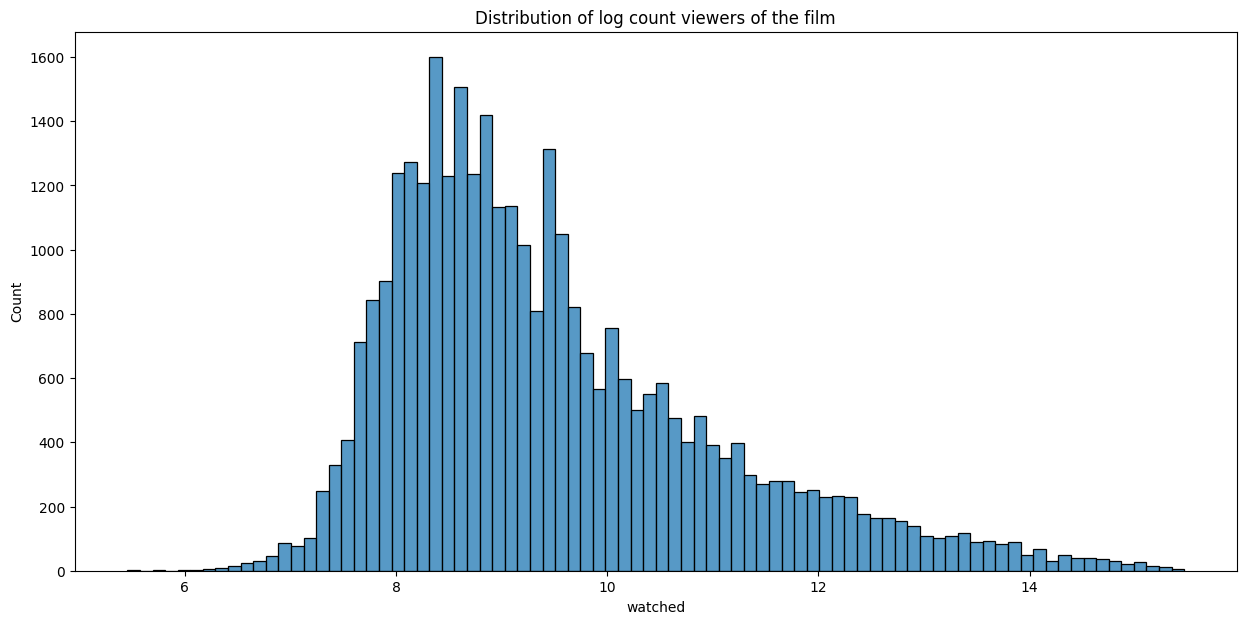

In [33]:
plt.figure(figsize=(15, 7))
sns.histplot(x=df_films["watched"].apply(np.log))
plt.title("Distribution of log count viewers of the film")
plt.show()

Distribution is now more look like normal, but still has large right "tail"

In [34]:
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print(df_films["watched"].describe())

count      32,878
mean       73,566
std       281,424
min           234
25%         4,300
50%         9,100
75%        29,000
max     5,200,000
Name: watched, dtype: float64


In [35]:
#20 most watched films on the dataset
df_films.sort_values(by="watched", ascending=False)[["name", "watched"]].head(20)

,name,watched
0,Barbie,5200000.0
3,Fight Club,5100000.0
9,Joker,5000000.0
1,Parasite,5000000.0
2,Interstellar,5000000.0
18,The Dark Knight,4500000.0
8,Pulp Fiction,4400000.0
15,The Truman Show,4400000.0
12,Get Out,4400000.0
4,La La Land,4400000.0


In [36]:
#Example of films around median on watched flims
df_films[df_films["watched"] == 9100][["name"]].head(10)

,name
25972,Forky Asks a Question: What Is a Pet?
27992,The Brothers Lionheart
15088,The Magic Gloves
20049,Leaves of Grass
26297,"The Chronicles of Narnia: The Lion, the Witch ..."
26489,Getting Even with Dad
13691,Beloved
13885,The Silent Twins
15414,20 Million Miles to Earth
16192,The Girl King


In [37]:
#Example of films around mean on watched flims
df_films[df_films["watched"] == 73_000][["name"]].head(10)

,name
5983,Victor Frankenstein
5606,Honey
5202,Papillon
5627,The Muppets Take Manhattan
3790,The Changeling
5989,Wine Country
5840,BASEketball
6771,Mother’s Day
4354,Frailty
2979,Saving Face


In [38]:
#10 least watched films on the dataset
df_films.sort_values(by="watched")[["name", "watched"]].head(10)

,name,watched
33445,Promises Written in Water,234.0
26302,I Wish You All the Best,244.0
33359,Winter Spring Summer or Fall,309.0
20406,Careful How You Go,330.0
20008,Americana,381.0
31224,Queen of the Lake,395.0
31091,We Bury the Dead,395.0
32834,Tree of Blood,441.0
32743,Heaven’s Story,464.0
29472,We Make Couples,465.0


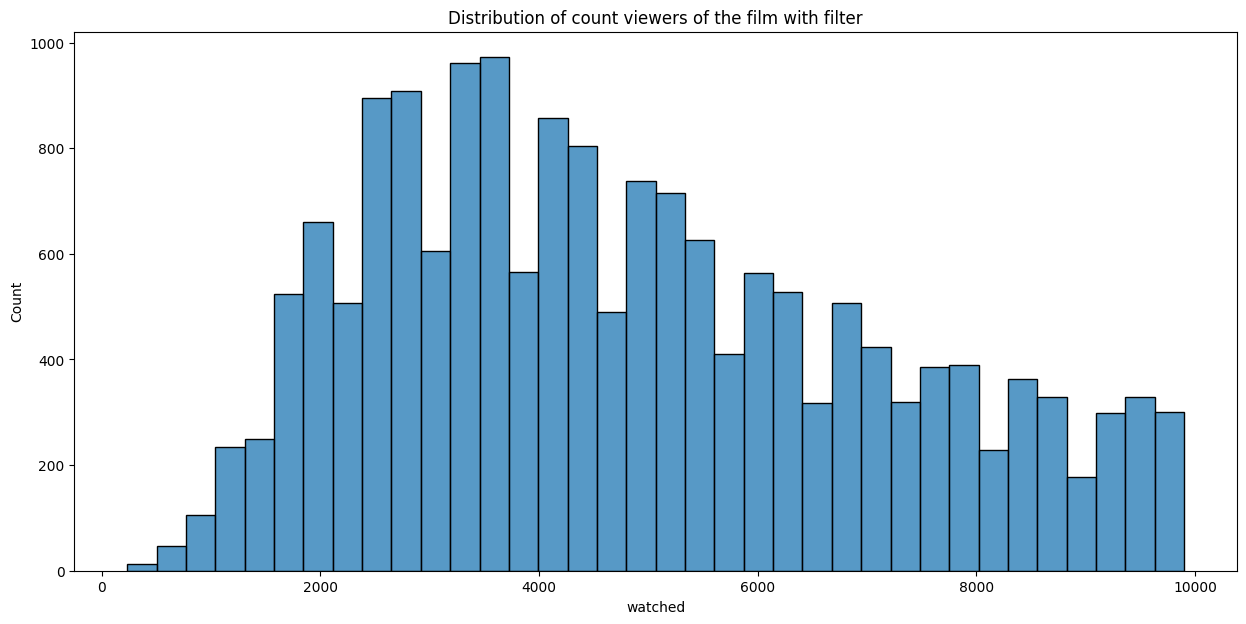

In [39]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films[df_films["watched"]<10_000], x="watched")
plt.title("Distribution of count viewers of the film with filter")
plt.show()

During parsing was expected to get film with more than aproximatly 2000 views in watched, but in  the dataset there are a lot of films with less 2000 and  even with only 234 views. For now better to leave these films

### Liked

In [40]:
print("Count of Nan: {} objects \n{}% in dataset".format(df_films["liked"].isna().sum(), round(df_films["liked"].isna().sum()/df_films.shape[0]*100, 2)))

Count of Nan: 1944 objects 
5.58% in dataset


Count and percentage of feature "liked" and "watch" are suspiciously equal

In [41]:
pd.crosstab(
    df_films["watched"].isna(), 
    df_films["watched"].isna(),
    rownames=["watched_isna"],
    colnames=["liked_isna"]
)

liked_isna,False,True
watched_isna,,
False,32878,0
True,0,1944


So if there is Nan in watched, so there is Nan in liked. Maybe elements with information about "watched" and "liked" are placed in the same block. However information about rating from in different place of the site

In [42]:
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print(df_films["liked"].describe())

count      32,878
mean       17,844
std        89,708
min            26
25%           750
50%         1,700
75%         5,600
max     2,700,000
Name: liked, dtype: float64


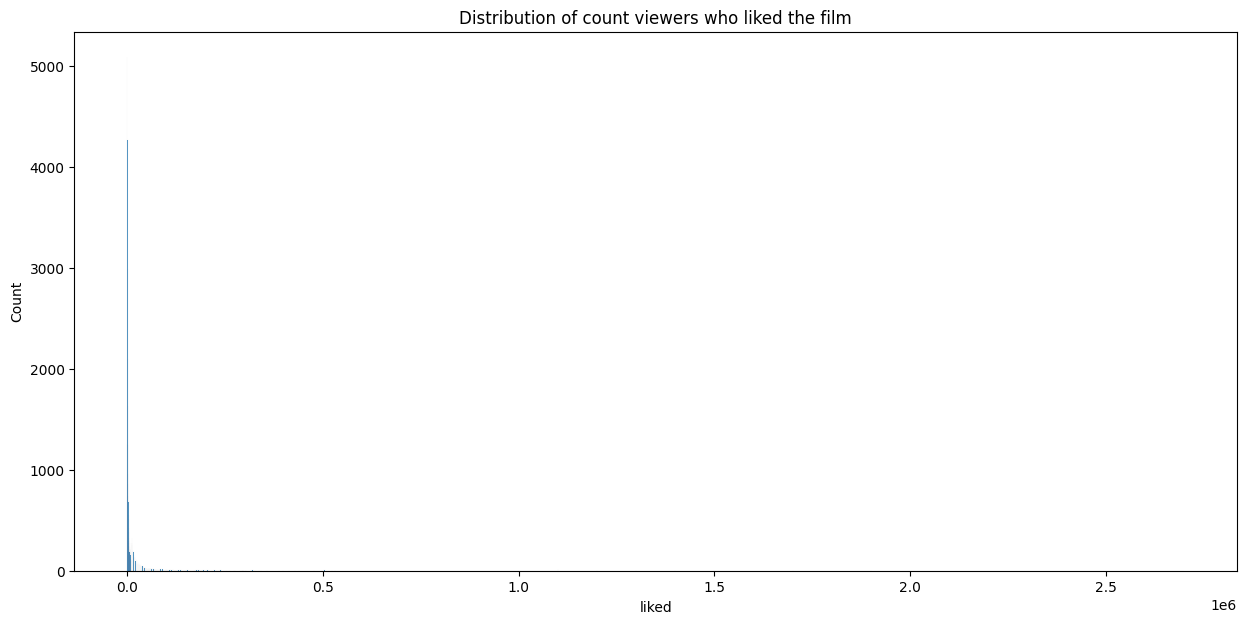

In [43]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films, x="liked")
plt.title("Distribution of count viewers who liked the film")
plt.show()

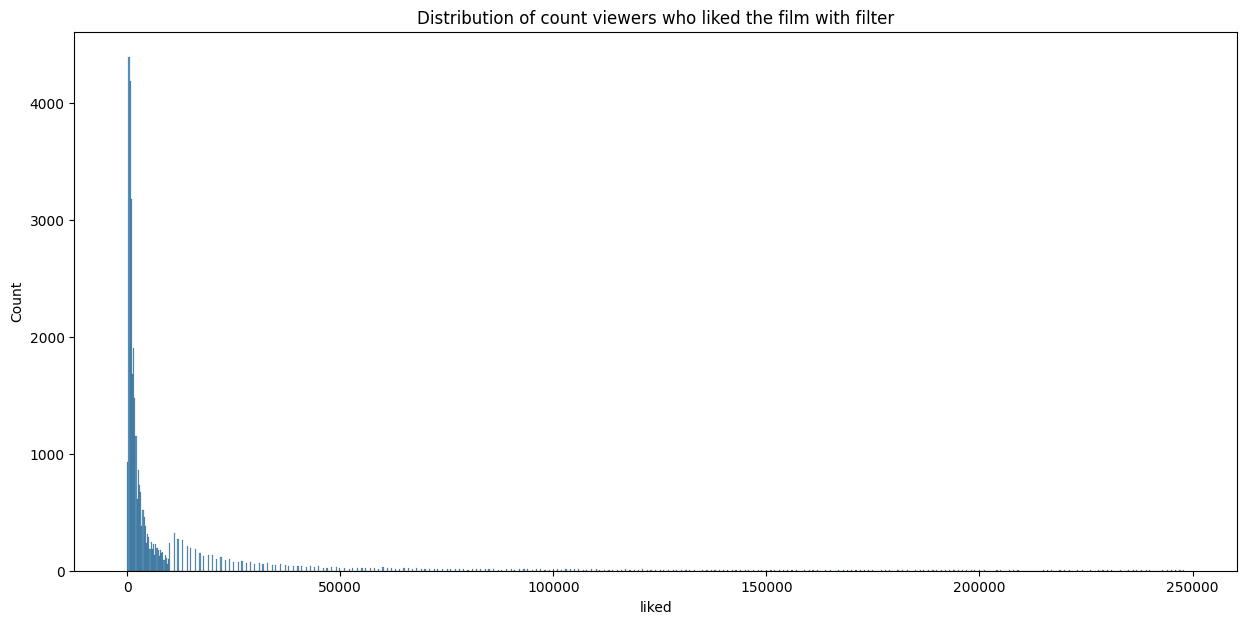

In [44]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films[df_films["liked"]<250_000], x="liked")
plt.title("Distribution of count viewers who liked the film with filter")
plt.show()

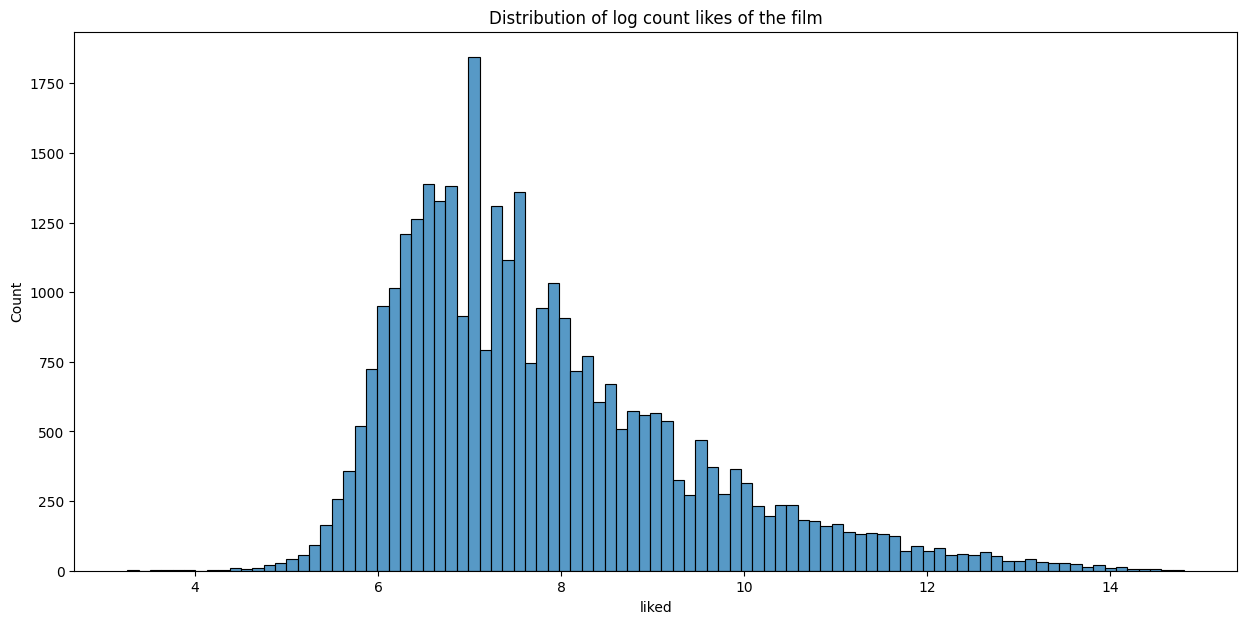

In [45]:
plt.figure(figsize=(15, 7))
sns.histplot(x=df_films["liked"].apply(np.log))
plt.title("Distribution of log count likes of the film")
plt.show()

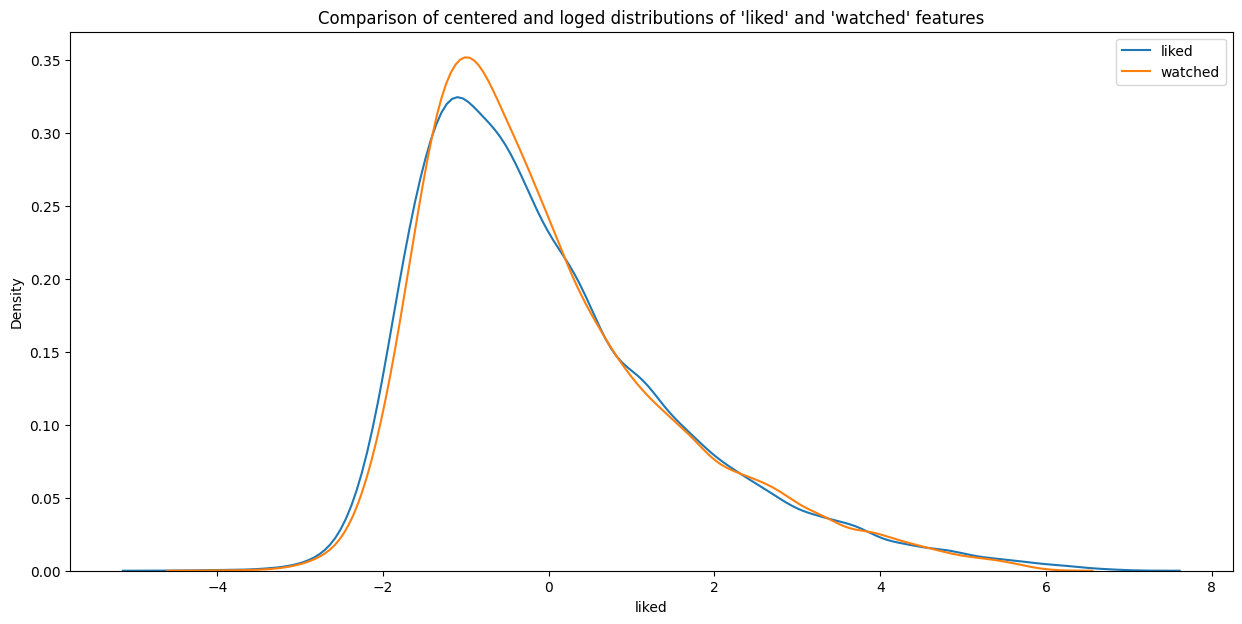

In [46]:
log_watched, log_liked = df_films["watched"].apply(np.log), df_films["liked"].apply(np.log)
mean_log_watched, mean_log_liked = log_watched.mean(), log_liked.mean()

plt.figure(figsize=(15, 7))
sns.kdeplot(x=log_liked-mean_log_liked, label="liked")
sns.kdeplot(x=log_watched-mean_log_watched, label="watched")
plt.title("Comparison of centered and loged distributions of 'liked' and 'watched' features")
plt.legend()
plt.show()

Distribution of likes is a little bit biased to the left and has lower peak. Obviously count of likes on the film is smaller then count of views, but likes also has higher variation 

### Top

In [47]:
print("Count of not Nan: {} objects \n{}% in dataset".format(df_films["top"].notna().sum(), round(df_films["top"].notna().sum()/df_films.shape[0]*100, 2)))

Count of not Nan: 249 objects 
0.72% in dataset


In [48]:
print("Count of unique values {}".format(df_films["top"].nunique()))

Count of unique values 249


This feature represents place of film in top 250, so there is only 249 not null values. We can create another binary feature "is_in_top"

### Duration

In [49]:
print("Count of Nan: {} objects \n{}% in dataset".format(df_films["duration"].isna().sum(), round(df_films["duration"].isna().sum()/df_films.shape[0]*100, 2)))

Count of Nan: 204 objects 
0.59% in dataset


In [50]:
#Most viewed films with NAN in duration 
df_films[df_films["duration"].isna()].sort_values(by="watched", ascending=False).head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade
1473,Twin Peaks: The Return,2017,Picks up 25 years after the inhabitants of a q...,377.0,666.0,344.0,1464.0,1219.0,5656.0,5882.0,22320.0,20292.0,88537.0,9.11,236000.0,...,[episode 17: ok maybe it all makes senseepisod...,It is happening again.,NaN,"[Kyle MacLachlan, Sheryl Lee, Laura Dern, Davi...",David Lynch,Mark Frost,Mark Frost,Peter Deming,None,"[Showtime Networks, Lynch/Frost Productions, R...","[France, USA]","[Crime, Drama, Thriller, Mystery]","[Humanity and the world around us, Intense vio...",https://letterboxd.com/film/twin-peaks-the-ret...,2010
3092,Jujutsu Kaisen,2020,Yuji Itadori is a boy with tremendous physical...,298.0,323.0,264.0,1041.0,1634.0,7424.0,12677.0,35988.0,21740.0,40191.0,8.50,174000.0,...,[rip junpei yoshino you would have loved lette...,A boy fights… for “the right death.”,NaN,[],Yui Umemoto,None,None,Teppei Ito,Yoshimasa Terui,"[MAPPA, Sumzap, Shueisha, MBS, TOHO]",[Japan],[Animation],"[Epic heroes, Superheroes in action-packed bat...",https://letterboxd.com/film/jujutsu-kaisen/,2020
3193,Fullmetal Alchemist: Brotherhood,2009,Disregard for alchemy’s laws ripped half of Ed...,143.0,148.0,92.0,410.0,536.0,2636.0,4541.0,18265.0,21406.0,63631.0,9.19,166000.0,...,"[this is one fucken long ass movie, *Fullmetal...",Humankind cannot gain anything without first g...,NaN,"[Romi Park, Rie Kugimiya, Shin-ichiro Miki, Fu...",Takahiro Ikezoe,None,Ryo Oyama,Mayuko Furumoto,Akira Senju,"[BONES, Aniplex, Square Enix, MBS, Techno Sound]",[Japan],"[Comedy, Animation]","[Epic heroes, Moving relationship stories, Emo...",https://letterboxd.com/film/fullmetal-alchemis...,2000
2372,NANA,2006,Nana Osaki is a guarded and ambitious young wo...,194.0,236.0,112.0,477.0,657.0,3037.0,4204.0,16698.0,12008.0,66918.0,9.23,141000.0,...,[the fact that the manga has been on hiatus fo...,None,NaN,"[Romi Park, KAORI, Akira Ishida, Megumi Kojima...",Morio Asaka,None,Manabu Tamura,Yukihiro Masumoto,Tomoki Hasegawa,"[VAP, Shueisha, Madhouse, Nippon Television Ne...",[Japan],"[Family, Drama, Animation, Comedy]",[],https://letterboxd.com/film/nana-2006/,2000
3182,Monster,2004,"Kenzou Tenma, a Japanese brain surgeon in Germ...",106.0,112.0,81.0,271.0,340.0,1549.0,2454.0,9926.0,11675.0,41787.0,9.26,93000.0,...,[Johan the type of guy to jerk off to abstract...,What would you do if a child you once saved gr...,NaN,[Hidenobu Kiuchi],Masayuki Kojima,None,Toshio Nakatani,Ryu Takizawa,Kuniaki Haishima,"[Shogakukan Production, Madhouse, VAP]",[Japan],"[Animation, Drama, Crime, Mystery]","[Thrillers and murder mysteries, Humanity and ...",https://letterboxd.com/film/monster-2004/,2000


In [51]:
print("Mean count of views of the films with NAN in duration {}".format(int(df_films[df_films["duration"].isna()]["watched"].mean())))

Mean count of views of the films with NAN in duration 15772


As I can judge most viewed films with NAN in duration are not actually films but series. Also on the website duration of those series is noted and it is in form "1,014" like in Twin Peaks: The Return. So, answer of, as i guess, most Nans in this feature is absence of handling cases where there is comma in string. However it appears in duration more than 1000 minutes and in this case it is series, but object of my project are films, so we can drop this objects

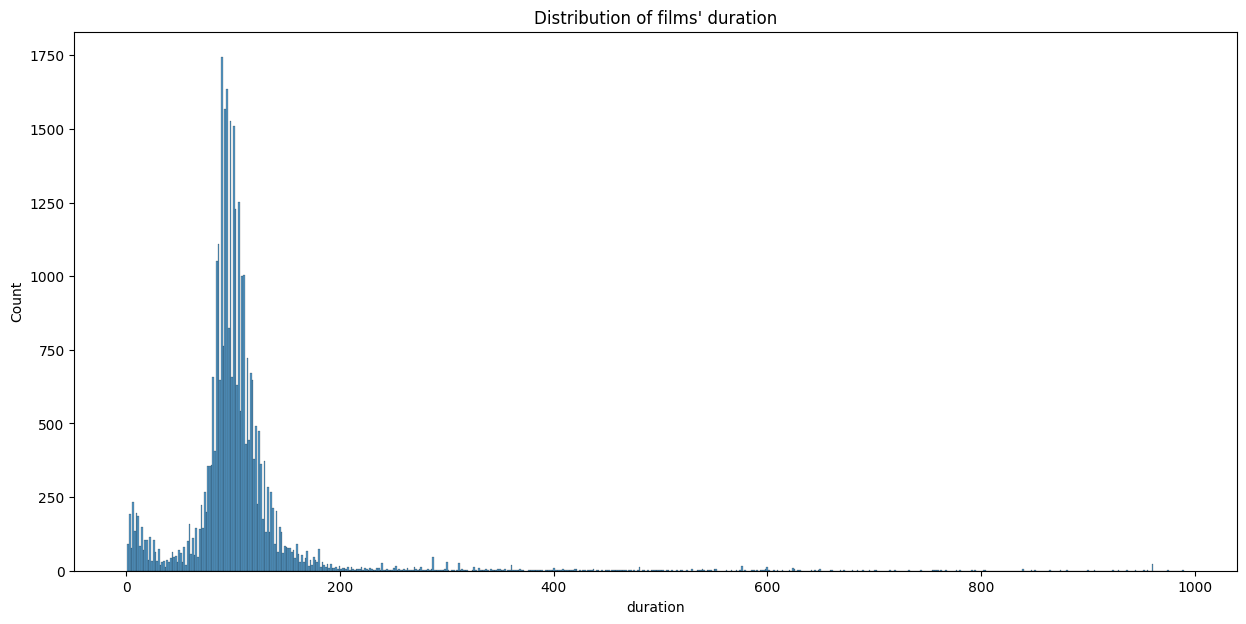

In [52]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films, x="duration")
plt.title("Distribution of films' duration")
plt.show()

Major peak is around 90 minutes - so it is standard duration of full-length films. Also there is smaller peak near 0 - it is short-cuts, and a lot of outliers from 200 minutes to the 1000 minutes. We need to decide thresholds to break this 3 categories. I'd define as feature film is from 60 to 240 minutes

In [53]:
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print(df_films["duration"].describe())

count   34,618
mean       105
std         67
min          1
25%         87
50%         98
75%        113
max        990
Name: duration, dtype: float64


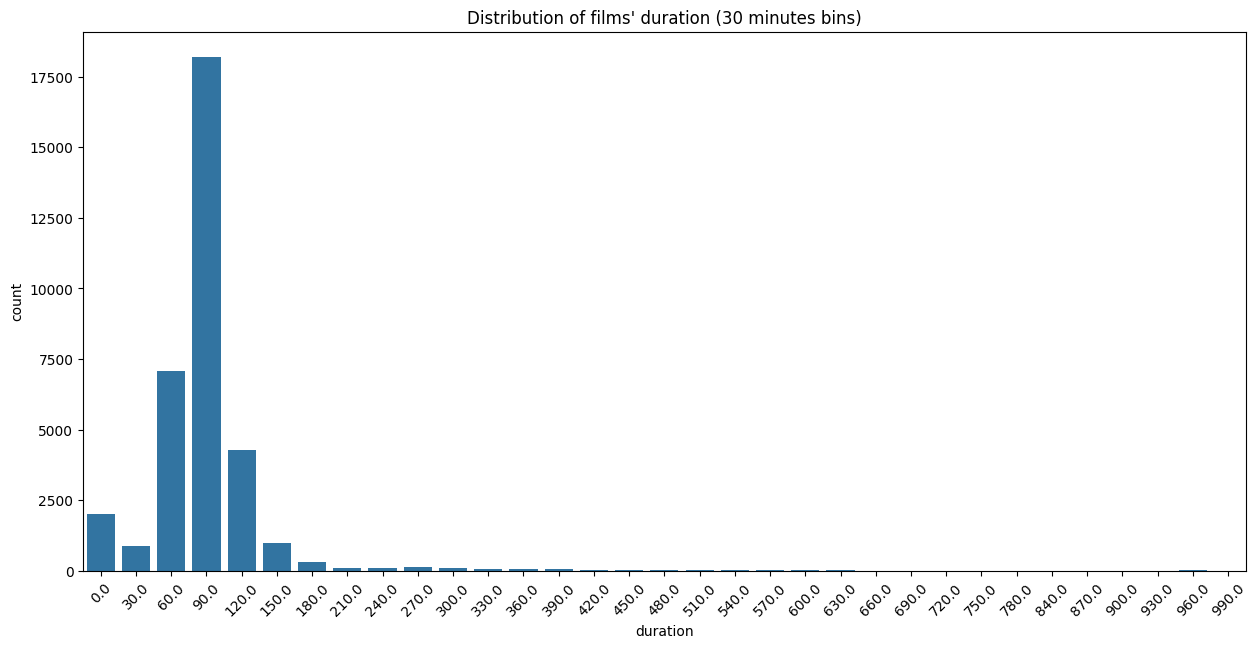

In [54]:
plt.figure(figsize=(15, 7))
sns.countplot(x=df_films["duration"]//30*30)
plt.xticks(rotation = 45)
plt.title("Distribution of films' duration (30 minutes bins)")
plt.show()

In [55]:
series_cnt, shortsut_cnt = df_films[df_films["duration"]>240]["name"].count(), df_films[df_films["duration"]<60]["name"].count()
print("Count of 'films' with duration more than 240 minutes: {}\nCount of 'films' with duration less than 60 minutes: {}\n Sum: {}\nPercentage: {}".format(shortsut_cnt, series_cnt, shortsut_cnt + series_cnt, round((shortsut_cnt + series_cnt)/df_films.shape[0]*100, 2)))

Count of 'films' with duration more than 240 minutes: 2878
Count of 'films' with duration less than 60 minutes: 800
 Sum: 3678
Percentage: 10.56


In [56]:
df_films[(df_films["duration"]>240)&(df_films["duration"]<270)].sort_values(by="watched", ascending=False).head(10)

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade
787,Zack Snyder’s Justice League,2021,Determined to ensure Superman’s ultimate sacri...,8205.0,13490.0,11170.0,33934.0,36762.0,91136.0,95744.0,120024.0,41170.0,47471.0,6.83,697000.0,...,"[Martin Scorsese having tears in his eyes, ope...",Us united.,242.0,"[Ben Affleck, Henry Cavill, Gal Gadot, Ray Fis...",Zack Snyder,Chris Terrio,Marianne Jenkins,Fabian Wagner,Tom Holkenborg,"[Warner Bros. Pictures, The Stone Quarry, Atla...",[USA],"[Action, Fantasy, Adventure]","[Epic heroes, Superheroes in action-packed bat...",https://letterboxd.com/film/zack-snyders-justi...,2020
2949,Cyberpunk: Edgerunners,2022,In a dystopia riddled with corruption and cybe...,188.0,273.0,281.0,1050.0,1497.0,5568.0,10612.0,30027.0,25523.0,36945.0,8.58,142000.0,...,"[Fuck you for breaking me, *playing 2077 after...",Just keep running.,250.0,"[KENN, Aoi Yuki, Hiroki Touchi, Takako Honda, ...",Yoshiyuki Kaneko,None,Bartosz Sztybor,Tetsuya Kawata,Akira Yamaoka,"[TRIGGER, CD PROJEKT RED, Netflix, Netflix]","[Japan, Poland, USA]",[Animation],"[Moving relationship stories, Emotional and ca...",https://letterboxd.com/film/cyberpunk-edgerunn...,2020
3757,Kill Bill: The Whole Bloody Affair,2006,An assassin is shot and almost killed by her r...,122.0,236.0,142.0,655.0,750.0,4229.0,5646.0,20631.0,14043.0,26136.0,8.61,137000.0,...,"[Let's face it, there really isn't a better wa...",One by Bloody one she Dealt Death…,247.0,"[Uma Thurman, Lucy Liu, Vivica A. Fox, Michael...",Quentin Tarantino,Quentin Tarantino,Lawrence Bender,Robert Richardson,RZA,"[Super Cool ManChu, Miramax, A Band Apart]","[Japan, USA]","[Thriller, Crime, Action]",[],https://letterboxd.com/film/kill-bill-the-whol...,2000
3968,Devilman Crybaby,2018,Akira Fudo learns from his best friend Ryo Asu...,514.0,604.0,532.0,1545.0,1903.0,5944.0,8681.0,21431.0,12860.0,22985.0,8.21,115000.0,...,"[whoever wrote this is so horny, There was my ...",None,250.0,"[Koki Uchiyama, Ayumu Murase, Megumi Han, Ami ...",Masaaki Yuasa,None,Yohei Shintaku,Toshikazu Hisano,Kensuke Ushio,"[Science SARU, Dynamic Planning, Aniplex]",[Japan],[Animation],"[Intense violence and sexual transgression, Ho...",https://letterboxd.com/film/devilman-crybaby/,2010
5372,Hamlet,1996,"Hamlet, Prince of Denmark, returns home to fin...",243.0,451.0,413.0,1522.0,1753.0,5647.0,5982.0,8764.0,2967.0,3552.0,7.20,58000.0,...,[ugh. at least make Hamlet a moody teen twink ...,Something is rotten in the state of Denmark.,242.0,"[Kenneth Branagh, Derek Jacobi, Kate Winslet, ...",Kenneth Branagh,Kenneth Branagh,David Barron,Alex Thomson,Patrick Doyle,[Castle Rock Entertainment],[USA],[Drama],"[Moving relationship stories, Captivating visi...",https://letterboxd.com/film/hamlet-1996/,1990
5140,Swarm,2023,A young woman’s obsession with a pop star take...,148.0,282.0,276.0,976.0,1364.0,5034.0,7211.0,13249.0,3996.0,5050.0,7.59,52000.0,...,"[Pearl you would’ve loved Dre, “who’s your fav...",Stan correct.,245.0,[Dominique Fishback],Donald Glover,None,Kris Baucom,Drew Daniels,Michael Uzowuru,"[Amazon Studios, Gilga, Big Indie Pictures, RB...",[USA],"[Comedy, Drama, Crime]","[Horror, the undead and monster classics, Drea...",https://letterboxd.com/film/swarm-2023-1/,2020
5482,Cleopatra,1963,"Determined to hold on to the throne, Cleopatra...",73.0,190.0,273.0,1366.0,2053.0,6542.0,6060.0,6017.0,1402.0,2241.0,6.94,44000.0,...,[i can't argue with risking it all for 60s eli...,The motion picture the world has been waiting ...,251.0,"[Elizabeth Taylor, Richard Burton, Rex Harriso...",Joseph L. Mankiewicz,Sidney Buchman,Walter Wanger,Leon Shamroy,Alex North,"[MCL Films S.A., Walwa Films S.A., 20th Centur...","[UK, USA]","[History, Drama, Romance]","[Epic history and literature, Lavish dramas an...",https://letterboxd.com/film/cleopatra-1963/,1960
8607,Dracula,2020,"Transylvania, 189

Among 10 most popular films with duration from 240 to 270 are only Zack Snyder’s Justice League(2021), Hamlet(1996), Cleopatra(1963), so rather to save threshold 240 minutes

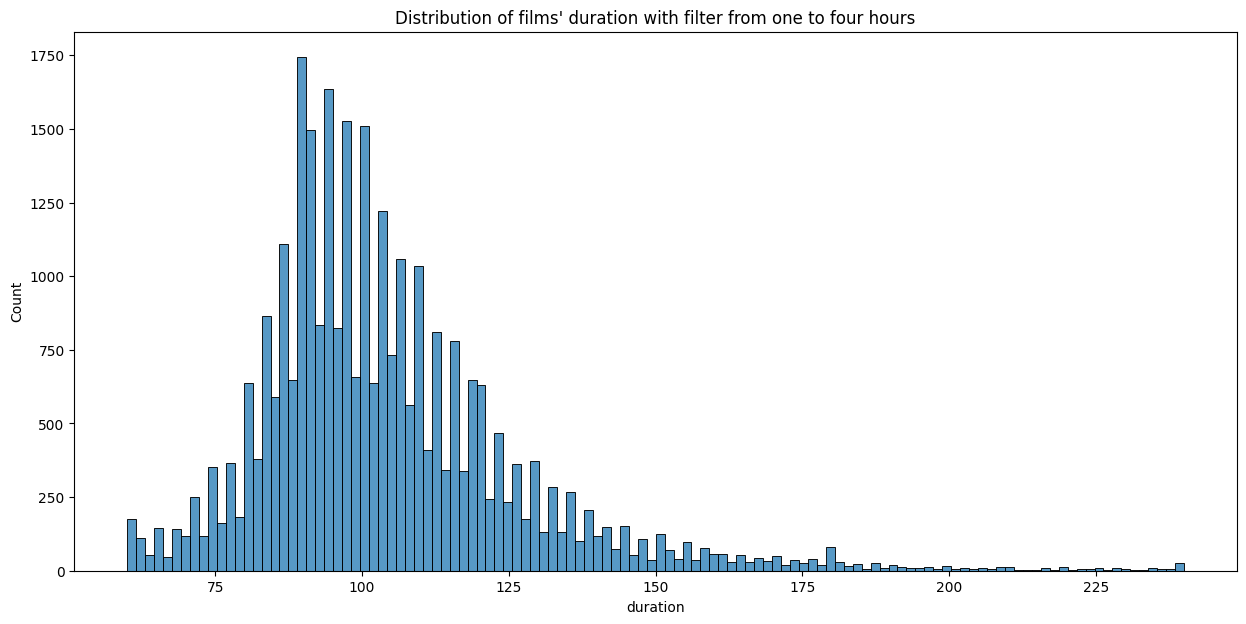

In [57]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_films[(df_films["duration"]>=60)&(df_films["duration"]<=240)], x="duration")
plt.title("Distribution of films' duration with filter from one to four hours")
plt.show()

Distribution has right tail, but before EDA I have espacted mean value bigger(around 120 minustes)

In [58]:
df_films = df_films[(df_films["duration"]>=60)&(df_films["duration"]<=240)]

### Crew director

In [59]:
print("Count of Nan: {} objects \n{}% in dataset".format(df_films["director"].isna().sum(), round(df_films["director"].isna().sum()/df_films.shape[0]*100, 2)))

Count of Nan: 21 objects 
0.07% in dataset


In [60]:
df_films[df_films["director"].isna()].head(21)

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade
11340,The Office Retrospective,2013,The cast and crew of the American version of T...,57.0,88.0,21.0,115.0,105.0,671.0,979.0,3909.0,2885.0,11130.0,9.05,30000.0,...,"[""I wish there was a way to know you were in t...",None,60.0,"[Greg Daniels, B.J. Novak, Mindy Kaling, Angel...",None,None,None,None,None,"[NBCUniversal, Universal Television]",[USA],[Documentary],[],https://letterboxd.com/film/the-office-retrosp...,2010
24362,Game of Thrones: The Story So Far,2017,The story of Game Of thrones before the TV ser...,15.0,28.0,12.0,47.0,51.0,197.0,318.0,1220.0,877.0,2359.0,8.82,8300.0,...,[just watched season 3 episode 9 and expirence...,None,65.0,[Sue Perkins],None,None,None,None,None,[],[],[Documentary],[],https://letterboxd.com/film/game-of-thrones-th...,2010
33755,Free to Play,2014,Follow three professional video game players a...,8.0,28.0,41.0,158.0,273.0,811.0,695.0,561.0,123.0,141.0,6.66,4500.0,...,[A few lessons learned from Free to Play:Stay ...,One game will change their lives.,75.0,"[Benedict Lim, Danil Ishutin, Clinton Loomis]",None,None,None,Nick Maggiore,Mark Adler,[Valve],"[Germany, Singapore, Ukraine, USA, China]",[Documentary],"[Moving relationship stories, Inspiring sports...",https://letterboxd.com/film/free-to-play/,2010
29038,Jazz Icons: Dexter Gordon Live in ’63 and ’64,2007,Dexter Gordon features three concerts filmed i...,22.0,26.0,31.0,77.0,167.0,423.0,897.0,1344.0,1062.0,552.0,7.82,5600.0,...,"[i imported my imdb ratings and i literally, g...",None,70.0,[Dexter Gordon],None,None,None,None,None,[],[],[],[],https://letterboxd.com/film/jazz-icons-dexter-...,2000
30941,Nirvana: Live at Reading,1992,This was the band’s second performance at the ...,11.0,5.0,3.0,6.0,17.0,144.0,157.0,720.0,365.0,1266.0,8.84,5700.0,...,[There's a moment in this show when Kurt asks ...,None,97.0,"[Kurt Cobain, Krist Novoselic, Dave Grohl, Ton...",None,None,None,None,None,"[Geffen Records, Festival Republic]",[UK],"[Documentary, Music]",[],https://letterboxd.com/film/nirvana-live-at-re...,1990
30116,The Grand Tour Presents: Seamen,2019,The route begins in Cambodia at Siem Reap and ...,2.0,8.0,7.0,33.0,86.0,434.0,915.0,1532.0,492.0,569.0,7.84,6700.0,...,[As long as these three are on screen together...,None,91.0,"[Jeremy Clarkson, James May, Richard Hammond]",None,None,Andy Wilman,Ben Joiner,None,[],[],"[Documentary, Comedy]",[],https://letterboxd.com/film/the-grand-tour-pre...,2010
35241,The Making of ‘Dune: Part One’,2022,Behind the scenes and bonus content from Dune ...,6.0,11.0,9.0,27.0,23.0,198.0,148.0,382.0,66.0,286.0,7.80,3200.0,...,"[LET ME IN LET ME IN LET ME INNNNNNN, Remarkab...",A look into the journey of creating ‘Dune’.,73.0,"[Denis Villeneuve, Patrice Vermette, Paul Lamb...",None,None,None,None,None,[],[USA],[Documentary],[],https://letterboxd.com/film/the-making-of-dune...,2020
30155,BLACKPINK: The Show,2021,A real journey into the quartet’s sound and ae...,31.0,21.0,15.0,58.0,51.0,271.0,193.0,658.0,211.0,1852.0,8.71,5800.0,...,"[lisa slapping jisoos ass everybody agreed, ci...",BLACKPINK’s First Livestream Concert,87.0,"[JISOO, JENNIE, ROSÉ, LISA]",None,None,Teddy Park,None,None,[YG Entertainment],[South Korea],[Music],[],https://letterboxd.com/film/blackpink-the-show/,2020
32564,TMZ Presents: The Downfall of Diddy,2024,A series of lawsuits and allegations have lege...,172.0,283.0,177.0,362.0,271.0,302.0,68.0,64.0,13.0,215.0,4.74,2800.0,...,"[I'm tryna cook some food, why it recommending...",From toxic behavior to explosive allegations,68.0,"[Sean Combs, Harvey Levin, Charles Latibeaudie...",None,None,None,Rob Castorina,None,"[TMZ, EHM Productions, Harvey Levin Productions]",[USA],"[Documentary, Crime]",[],https://letterboxd.com/film/tmz-presents-the-d...,2020
32393,Orelsan: Never Show This to Anyone,2021,"In the early 2000s, Aur

Represatned films are mostly TV-shows, documentaries and "making of" films. We can drop those films, becouse director is important feature and there is only 21 of films without director

In [61]:
df_films = df_films.dropna(subset=["director"])

In [62]:
directors = df_films.groupby(by="director").agg({"watched": "mean", "name": "count", "year": ["max", "min"], "rating":"mean"})

In [63]:
#Most prodactive directors
directors.sort_values(by=('name', 'count'), ascending=False).head(10)

watched  name  year          rating
                           mean count   max   min      mean
director                                                   
Alfred Hitchcock  140102.000000    53  1976  1925  6.676471
Woody Allen        92801.923077    52  2023  1966  6.667308
John Ford          20792.857143    45  1965  1924  7.200000
Ingmar Bergman     49931.818182    44  2003  1946  7.287955
Takashi Miike      25513.513514    40  2023  1995  6.714595
Clint Eastwood    140500.000000    40  2024  1971  6.674474
Jean-Luc Godard    41650.000000    40  2018  1960  7.094615
Werner Herzog      31871.052632    38  2022  1970  7.185000
Martin Scorsese   606669.444444    38  2023  1967  7.607222
Steven Spielberg  731700.000000    37  2022  1971  7.028108

In [64]:
#Most popular directors
directors.sort_values(by=('watched', 'mean'), ascending=False).head(10)

watched  name  year          rating
                         mean count   max   min      mean
director                                                 
Bob Persichetti     4400000.0     1  2018  2018  8.830000
Greta Gerwig        3800000.0     3  2023  2017  7.993333
Pete Docter         3450000.0     4  2020  2001  8.002500
Justin K. Thompson  3100000.0     1  2023  2023  8.870000
Jordan Peele        3000000.0     3  2022  2017  7.766667
Lee Unkrich         2850000.0     2  2017  2010  8.110000
Christopher Nolan   2553000.0    12  2023  1998  7.877500
Quentin Tarantino   2362800.0    10  2019  1992  8.052000
Ari Aster           2348000.0     3  2023  2018  7.493333
Joe Russo           2323000.0     6  2022  2014  7.086667

In [65]:
#Most high rated directors
directors[directors[("name", "count")]>=3].sort_values(by=('rating', 'mean'), ascending=False).head(10)

watched  name  year          rating
                             mean count   max   min      mean
director                                                     
Park Jun-soo          8922.222222     9  2024  2018  9.213333
Beyoncé              63333.333333     3  2023  2019  8.906667
Oh Yoon-dong          5971.428571     7  2024  2021  8.820000
Paul Dugdale         36428.571429     8  2024  2014  8.748750
Cliff Stephenson      8600.000000     3  2020  2014  8.686667
Sam Wrench           94900.000000     4  2024  2016  8.587500
Marilou Diaz-Abaya    2700.000000     3  1983  1980  8.460000
Daoud Abdel Sayed     4550.000000     3  2010  1991  8.410000
Jon Bois              5680.000000     5  2022  2018  8.380000
Satoshi Kon         491750.000000     4  2006  1997  8.360000

6 of ten represanted directors are making films about music tour or something simular. Better to find way to take apart such films

In [66]:
#Most high rated directors
directors[(directors[("name", "count")]>=3) & (directors[("watched", "mean")]>100_000)].sort_values(by=('rating', 'mean'), ascending=False).head(10)

watched  name  year          rating
                           mean count   max   min      mean
director                                                   
Satoshi Kon        4.917500e+05     4  2006  1997  8.360000
Hayao Miyazaki     1.339917e+06    12  2023  1979  8.302500
Andrei Tarkovsky   1.618625e+05     8  1986  1962  8.278750
Richard Ayoade     1.321250e+05     4  2013  2004  8.107500
Quentin Tarantino  2.362800e+06    10  2019  1992  8.052000
Matthew Warchus    1.243333e+05     3  2022  2014  8.050000
Pete Docter        3.450000e+06     4  2020  2001  8.002500
Greta Gerwig       3.800000e+06     3  2023  2017  7.993333
Tony Kaye          3.819000e+05     3  2011  1998  7.960000
Elem Klimov        1.382667e+05     4  1985  1964  7.956667

In [67]:
directors["career_span"] = directors[("year", "max")] - directors[("year", "min")]
directors.sort_values(by="career_span", ascending=False).head(10)

watched  name  year          rating career_span
                               mean count   max   min      mean            
director                                                                   
Orson Welles           98321.428571    15  2020  1941  7.655714          79
Manoel de Oliveira      3140.000000    11  2010  1942  7.543333          68
Agnès Varda            35966.347826    23  2019  1955  7.603478          64
Andrzej Wajda           8709.090909    11  2016  1955  7.389091          61
Francis Ford Coppola  335930.434783    23  2024  1963  6.789130          61
Roman Polanski        154078.260870    23  2023  1962  6.885217          61
Jean-Luc Godard        41650.000000    40  2018  1960  7.094615          58
Marco Bellocchio        8800.000000    12  2023  1965  7.267000          58
Ken Loach              19887.500000    24  2023  1966  7.197917          57
Jerzy Skolimowski      17570.000000    11  2022  1965  6.888000          57

### Crew writer

In [68]:
df_films.columns

Index(['name', 'year', 'description', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', 'rating', 'watched', 'liked', 'top', 'popular_reviews',
       'tagline', 'duration', 'actors', 'director', 'writer', 'producer',
       'cinematography', 'composer', 'studio', 'country', 'genres', 'themes',
       'link', 'decade'],
      dtype='object')

In [69]:
print("Count of Nan: {} objects \n{}% in dataset".format(df_films["writer"].isna().sum(), round(df_films["writer"].isna().sum()/df_films.shape[0]*100, 2)))

Count of Nan: 1566 objects 
5.06% in dataset


In [70]:
df_films[df_films["writer"].isna()].sort_values(by="watched", ascending=False).head(10)

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade
941,Alice in Wonderland,1951,"On a golden afternoon, wildly curious young Al...",921.0,3054.0,2558.0,14344.0,16927.0,74163.0,67202.0,110545.0,29619.0,80373.0,7.57,921000.0,...,[Tim Burton's live-action remake found dead in...,A world of wonders in one great picture!,75.0,"[Kathryn Beaumont, Ed Wynn, Richard Haydn, Ste...",Clyde Geronimi,None,Walt Disney,None,Oliver Wallace,[Walt Disney Productions],[USA],"[Fantasy, Animation, Family, Adventure]","[Fairy-tale fantasy and enchanted magic, Kids'...",https://letterboxd.com/film/alice-in-wonderlan...,1950
1248,Bambi,1942,Bambi’s tale unfolds from season to season as ...,1148.0,3937.0,3153.0,18838.0,20577.0,82857.0,58404.0,72760.0,14339.0,36899.0,6.98,833000.0,...,[Here are some reasons why Bambi is the greate...,A great love story.,70.0,"[Donnie Dunagan, Peter Behn, Stan Alexander, C...",David Hand,None,Walt Disney,None,Frank Churchill,[Walt Disney Productions],[USA],"[Drama, Animation, Family]","[Adorable animals and heartwarming families, F...",https://letterboxd.com/film/bambi/,1940
1206,Cinderella,1950,Cinderella has faith her dreams of a better li...,713.0,2790.0,2916.0,17085.0,22251.0,89239.0,64743.0,76511.0,14603.0,44750.0,7.07,827000.0,...,"[The dog in this is named Bruno, how come we d...",The greatest love story ever told.,74.0,"[Ilene Woods, Eleanor Audley, Verna Felton, Cl...",Hamilton Luske,None,Walt Disney,None,Oliver Wallace,[Walt Disney Productions],[USA],"[Fantasy, Animation, Family, Romance]","[Song and dance, Fairy-tale fantasy and enchan...",https://letterboxd.com/film/cinderella/,1950
1344,One Hundred and One Dalmatians,1961,When a litter of dalmatian puppies are abducte...,326.0,1634.0,1597.0,10274.0,14736.0,69113.0,61638.0,77887.0,16871.0,38648.0,7.28,750000.0,...,[My favorite part is when 101 dogs try to disg...,The Canine Caper of the Century,79.0,"[Rod Taylor, J. Pat O'Malley, Betty Lou Gerson...",Hamilton Luske,None,Walt Disney,None,George Bruns,[Walt Disney Productions],[USA],"[Animation, Comedy, Family, Adventure]","[Adorable animals and heartwarming families, K...",https://letterboxd.com/film/one-hundred-and-on...,1960
1439,Peter Pan,1953,"Leaving the safety of their nursery behind, We...",1029.0,3161.0,2997.0,14825.0,18729.0,72052.0,59247.0,66420.0,12690.0,27915.0,6.96,720000.0,...,[Honestly could have been the best classic Dis...,It will live in your heart forever!,77.0,"[Bobby Driscoll, Kathryn Beaumont, Hans Conrie...",Clyde Geronimi,None,Walt Disney,None,Oliver Wallace,[Walt Disney Productions],[USA],"[Fantasy, Animation, Family, Adventure]","[Fairy-tale fantasy and enchanted magic, Kids'...",https://letterboxd.com/film/peter-pan/,1950
1466,The Jungle Book,1967,The boy Mowgli makes his way to the man-villag...,464.0,1700.0,1609.0,10045.0,14159.0,63529.0,60437.0,80701.0,17894.0,30086.0,7.24,713000.0,...,[monkey mondays #16the song with the monkeys w...,The Jungle is JUMPIN’!,78.0,"[Bruce Reitherman, Phil Harris, Sebastian Cabo...",Wolfgang Reitherman,None,Walt Disney,None,George Bruns,[Walt Disney Productions],[USA],"[Family, Animation, Adventure]","[Song and dance, Fairy-tale fantasy and enchan...",https://letterboxd.com/film/the-jungle-book/,1960
1470,Lady and the Tramp,1955,"Lady, a golden cocker spaniel, meets up with a...",381.0,1790.0,1884.0,12546.0,17124.0,71808.0,56634.0,63767.0,12356.0,31801.0,7.08,700000.0,...,"[“Come on, bitch.”, I hope she made lotsa spag...",She’s from the leash and license set… he’s foo...,76.0,"[Barbara Luddy, Larry Roberts, Peggy Lee, Bill...",Hamilton Luske,None,Walt Disney,None,Oliver Wallace,[Walt Disney Productions],[USA],"[Romance, Family, Animation]","[Adorable animals and heartwarming families, F...",https://letterboxd.com/film/lady-and-the-tramp/,1950
661,Baby Reindeer,2024,When a struggling comedian shows one act of k

Most of the most popular films wihtout writer are directed in Walt Disney's studio. Also there is tv-series. Further there are a lot of documentaries.

Some films have "story" block inplace of "writer"

In [71]:
df_writer_nan = df_films[df_films["writer"].isna()]

In [72]:
df_writer_nan["studio"].explode().value_counts().head(10)

studio
HBO Documentary Films          66
BBC                            25
RadicalMedia                   22
Impact Partners                15
Amazon Studios                 15
Artemis Rising                 15
JustFilms / Ford Foundation    14
Walt Disney Productions        14
RAW                            13
Propagate Content              13
Name: count, dtype: int64

In [73]:
#Percentage of genres where writer is None
round(df_writer_nan["genres"].explode().value_counts(normalize=True)*100, 2).head()

genres
Documentary    42.83
Music          10.41
Drama           9.79
Comedy          6.75
Crime           5.36
Name: proportion, dtype: float64

43% and 10% of films without writer are documentaries and about music. These genres probably will be removed, it will be in genres section

In [74]:
print("Writer and director are the same person {}%\nWriter and producer are the same person {}%".format(
    round(df_films[df_films["director"]==df_films["writer"]]["name"].count()/df_films.shape[0]*100, 2),
    round(df_films[df_films["producer"]==df_films["writer"]]["name"].count()/df_films.shape[0]*100, 2)
))

Writer and director are the same person 38.3%
Writer and producer are the same person 7.33%


In more of 38% cases writer and director are the same person. So I'd filled writer feature with person in the director. But it is categorical feature and maybe in the future would be one-hot encoded or target encoded so it existing of Nan is not big deal.

In [75]:
#Replacing Nan with director
#df_films[df_films["writer"].isna()]["writer"] = df_films[df_films["writer"].isna()]["director"] 

In [76]:
def get_crew_member_df(df, crew_position):
    result = df.groupby(by=crew_position).agg({"watched": "mean", "name": "count", "year": ["max", "min"], "rating":"mean"})
    result.columns = ['watched_mean', 'count_films', 'last_film', 'debute', 'mean_rating']
    return result

In [77]:
writers = get_crew_member_df(df_films, "writer")

In [78]:
#Most productive writers
writers.sort_values(by="count_films", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
writer,,,,,
Woody Allen,89619.607843,51,2023,1965,6.661961
Ingmar Bergman,52871.794872,39,2003,1944,7.378718
Jean-Luc Godard,46400.000000,35,2018,1960,7.139412
Hong Sang-soo,11808.823529,34,2024,1996,7.157353
Werner Herzog,26847.058824,34,2022,1970,7.153824
Luc Besson,161900.000000,30,2023,1983,5.918966
John Hughes,477444.444444,27,2021,1983,6.179630
Tyler Perry,13834.615385,26,2024,2005,5.438462
Jean-Claude Carrière,26095.454545,23,2021,1965,6.785455


In [79]:
#Writers with the highest rating with more then 10 films
writers[writers["count_films"]>10].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
writer,,,,,
Hayao Miyazaki,1.219071e+06,14,2023,1979,8.270714
Satyajit Ray,1.301905e+04,22,1991,1955,7.888182
Abbas Kiarostami,4.873333e+04,16,2017,1974,7.842500
David Lynch,4.212364e+05,11,2007,1977,7.838182
Quentin Tarantino,1.762571e+06,14,2019,1992,7.787857
Kōgo Noda,3.307143e+04,14,1962,1930,7.760714
Robert Bresson,4.100833e+04,12,1983,1945,7.685000
Tonino Guerra,1.975385e+04,14,1998,1970,7.655385
Federico Fellini,5.830000e+04,14,1983,1952,7.645000


In [80]:
#Writers with the highest number of views with more then 10 films
writers[writers["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
writer,,,,,
Steve Kloves,1.943109e+06,11,2011,1984,7.338182
Quentin Tarantino,1.762571e+06,14,2019,1992,7.787857
Hayao Miyazaki,1.219071e+06,14,2023,1979,8.270714
James Gunn,8.906071e+05,15,2023,1950,6.706429
Noah Baumbach,8.236867e+05,15,2023,1995,6.910667
M. Night Shyamalan,6.270867e+05,15,2024,1992,5.684000
Lawrence Kasdan,5.958889e+05,11,2018,1981,6.932222
David Koepp,5.221773e+05,22,2024,1990,6.356818
John Hughes,4.774444e+05,27,2021,1983,6.179630


In [81]:
writers["career_span"] = writers["last_film"] - writers["debute"]
writers.sort_values(by="career_span", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating,career_span
writer,,,,,,
Noël Coward,29520.000000,5,2019,1933,7.106000,86
James Gunn,890607.142857,15,2023,1950,6.706429,73
Carl Theodor Dreyer,33025.000000,9,1988,1920,7.531250,68
Agnès Varda,40756.300000,20,2019,1955,7.628000,64
Tennessee Williams,33012.500000,8,2014,1951,7.175000,63
Oscar Hammerstein II,5300.000000,3,1999,1936,6.880000,63
Fritz Lang,50350.000000,8,1984,1921,7.522500,63
Allan Scott,31112.500000,8,1996,1935,6.623750,61
Francis Ford Coppola,255842.857143,14,2024,1963,6.625714,61


### Crew producer

In [82]:
cnt_nan_feature(df_films, "producer")

Count of Nan: 2810 objects 
9.09% in dataset


In [83]:
producers = get_crew_member_df(df_films, "producer")

In [84]:
#Most productive producers
producers.sort_values(by="count_films", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
producer,,,,,
Brian Grazer,196542.857143,49,2020,1982,6.179592
Tim Bevan,260002.222222,47,2024,1985,6.401778
Roger Corman,10213.888889,42,2017,1955,5.651053
Jason Blum,428836.842105,38,2024,2008,5.394211
Pandro S. Berman,9102.941176,36,1963,1932,6.730588
Hal B. Wallis,40941.935484,35,1975,1931,6.910968
Scott Rudin,418837.500000,33,2019,1984,6.653125
Paulo Branco,7014.285714,33,2015,1981,7.308621
Darryl F. Zanuck,16840.000000,32,1962,1925,6.795333


In [85]:
#Producers with the highest rating with more then 10 films
producers[producers["count_films"]>10].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
producer,,,,,
Franco Cristaldi,1.790000e+04,13,1979,1957,7.769091
Elías Querejeta,1.546364e+04,11,2002,1966,7.677273
Toshio Suzuki,8.312727e+05,11,2020,1992,7.620909
Michael Powell,5.101000e+04,11,1969,1941,7.608000
Alfred Hitchcock,3.475882e+05,18,1976,1946,7.568235
Alain Poiré,2.242308e+04,13,1998,1956,7.526923
Lawrence Bender,1.506975e+06,12,2009,1992,7.523333
Frederick Wiseman,4.913333e+03,18,2018,1963,7.494667
Allan Ekelund,7.609231e+04,13,1964,1950,7.464615


In [86]:
#Producers with the highest number of views with more then 10 films
producers[producers["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
producer,,,,,
Kevin Feige,2.833333e+06,15,2019,2011,6.974000
David Heyman,1.910408e+06,13,2019,1994,7.348462
Lawrence Bender,1.506975e+06,12,2009,1992,7.523333
Toshio Suzuki,8.312727e+05,11,2020,1992,7.620909
Tim Burton,6.825455e+05,11,2016,1990,6.667273
Avi Arad,6.556750e+05,12,2024,2003,5.331667
Kathleen Kennedy,5.816429e+05,14,2019,1982,6.622857
Eric Fellner,5.803125e+05,16,2024,1986,6.695625
John Hughes,5.610625e+05,16,1997,1986,6.386875


Marvel, Harry Potter, Quentin Tarantino and Gibli.

In [87]:
producers["career_span"] = producers["last_film"] - producers["debute"]
producers.sort_values(by="career_span", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating,career_span
producer,,,,,,
Erich Pommer,46294.117647,18,1984,1920,7.290588,64
Roger Corman,10213.888889,42,2017,1955,5.651053,62
Albert Band,8028.571429,7,2023,1967,5.968571,56
Frederick Wiseman,4913.333333,18,2018,1963,7.494667,55
David Lewis,7180.000000,6,1993,1939,6.910000,54
Dino De Laurentiis,39668.965517,30,2001,1949,6.743333,52
Edward R. Pressman,53015.384615,14,2024,1972,6.112308,52
Jérôme Seydoux,29620.000000,10,2022,1971,5.869000,51
Francis Ford Coppola,330923.076923,13,2011,1963,6.823077,48


### Crew cinematography

In [88]:
cnt_nan_feature(df_films, "cinematography")

Count of Nan: 2686 objects 
8.69% in dataset


In [89]:
cinematogrophists = get_crew_member_df(df_films, "cinematography")

In [90]:
#Most productive cinematogrophists
cinematogrophists.sort_values(by="count_films", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
cinematography,,,,,
Mark Irwin,220634.615385,53,2023,1979,5.825962
John Bailey,104692.000000,51,2017,1978,6.337347
Dean Semler,156703.921569,51,2019,1981,5.710196
Roger Deakins,485300.000000,49,2022,1984,7.103673
Dean Cundey,463365.116279,48,2017,1974,6.245116
Michael Ballhaus,171393.333333,46,2013,1971,7.039111
Robert Elswit,232702.272727,45,2024,1985,6.436136
Sven Nykvist,63595.555556,45,1998,1953,7.137111
Andrew Dunn,174513.333333,45,2024,1991,6.262444


In [91]:
#Cinematogrophists with the highest rating with more then 10 films
cinematogrophists[cinematogrophists["count_films"]>10].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
cinematography,,,,,
Asakazu Nakai,103169.230769,13,1985,1946,8.164615
Yûharu Atsuta,30637.500000,16,1962,1941,7.819375
Atsushi Okui,787582.352941,17,2023,1986,7.804118
Walter Carvalho,25083.333333,18,2018,1989,7.753889
Acácio de Almeida,2881.307692,15,2018,1976,7.691538
Lauro Escorel,6063.636364,11,2015,1972,7.683636
Ghislain Cloquet,37875.230769,14,1979,1960,7.635385
Gabriel Figueroa,16010.526316,19,1984,1944,7.594737
Tatsuo Suzuki,11712.571429,14,1988,1965,7.590714


In [92]:
#cinematogrophists with the highest number of views with more then 10 films
cinematogrophists[cinematogrophists["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
cinematography,,,,,
Hoyte van Hoytema,1.783727e+06,11,2023,2008,7.509091
Wally Pfister,1.352579e+06,14,2012,1991,7.177857
Linus Sandgren,1.040923e+06,13,2023,2010,6.660769
Greig Fraser,1.039571e+06,15,2024,2006,6.988571
Andrew Lesnie,9.652706e+05,17,2014,1986,6.692353
Pawel Pogorzelski,8.068091e+05,11,2023,2014,6.448182
Atsushi Okui,7.875824e+05,17,2023,1986,7.804118
Bill Pope,7.806875e+05,32,2024,1990,6.514062
Jo Willems,7.059071e+05,14,2023,2005,6.700000


In [93]:
cinematogrophists["career_span"] = cinematogrophists["last_film"] - cinematogrophists["debute"]
cinematogrophists.sort_values(by="career_span", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating,career_span
cinematography,,,,,,
Jack Draper,3650.000000,3,1992,1936,7.700000,56
Eduard Tisse,40128.571429,7,1979,1925,7.622857,54
Anthony B. Richmond,137368.421053,43,2022,1968,6.111842,54
László Kovács,99250.000000,41,2020,1967,6.410250,53
Vittorio Storaro,82807.407407,28,2023,1970,6.550370,53
Oliver Wood,219029.268293,41,2022,1970,5.914000,52
Diego Bonacina,1900.000000,2,2020,1968,6.725000,52
Renato Berta,7862.500000,24,2023,1971,7.063750,52
Geoffrey Unsworth,140044.444444,19,2006,1954,7.017778,52


#### Duets directors and cinematography

In [94]:
print("Director and cinematographist are the same person {}%".format(
    round(df_films[df_films["director"]==df_films["cinematography"]]["name"].count()/df_films.shape[0]*100, 2)
))

Director and cinematographist are the same person 2.6%


In [95]:
directors_cin_duets = get_crew_duets(df_films, "director", "cinematography")

In [96]:
directors_cin_duets["career_span"] = directors_cin_duets["year_max"] - directors_cin_duets["year_min"]

In [97]:
directors_cin_duets.sort_values(by="career_span", ascending=False).head(10)

,director,cinematography,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film,career_span
17445,Sergei Eisenstein,Eduard Tisse,7,7.622857,7.81,40128.571429,173000.0,1979,1925,Battleship Potemkin,54
9522,Jonas Mekas,Jonas Mekas,6,7.720000,8.24,4263.500000,10000.0,2005,1961,Reminiscences of a Journey to Lithuania,44
8015,Jan Troell,Jan Troell,4,7.910000,8.41,5350.000000,9400.0,2008,1966,The Emigrants,42
14416,Orson Welles,Gary Graver,3,7.373333,7.67,11166.666667,30000.0,2020,1978,The Other Side of the Wind,42
299,Aki Kaurismäki,Timo Salminen,17,7.285882,7.88,31605.882353,224000.0,2023,1983,Fallen Leaves,40
310,Akira Kurosawa,Asakazu Nakai,11,8.220909,9.01,120672.727273,472000.0,1985,1946,Seven Samurai,39
5929,Frederick Wiseman,John Davey,10,7.184000,8.20,3090.000000,6700.0,2022,1983,Ex Libris: The New York Public Library,39
12045,Marcell Jankovics,Zoltán Bacsó,3,8.126667,8.38,10733.333333,24000.0,2011,1973,Son of the White Mare,38
73,Abel Ferrara,Ken Kelsch,9,6.766250,7.27,15422.222222,42000.0,2014,1979,The Addiction,35
5902,Fred Schepisi,Ian Baker,9,6.341111,7.27,14977.777778,51000.0,2013,1978,Roxanne,35


In [98]:
directors_cin_duets.sort_values(by="count_films", ascending=False).head(10)

,director,cinematography,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film,career_span
18273,Steven Soderbergh,Steven Soderbergh,28,6.438214,7.77,190071.964286,1500000.0,2024,1996,Ocean’s Eleven,28
7396,Ingmar Bergman,Sven Nykvist,21,7.635238,8.73,63204.761905,463000.0,1984,1953,Persona,31
9417,Johnnie To,Cheng Siu-Keung,21,7.324762,7.95,7376.190476,20000.0,2015,1998,Drug War,17
18280,Steven Spielberg,Janusz Kamiński,20,7.071500,8.91,738200.000000,2500000.0,2022,1993,Catch Me If You Can,29
299,Aki Kaurismäki,Timo Salminen,17,7.285882,7.88,31605.882353,224000.0,2023,1983,Fallen Leaves,40
19869,Werner Herzog,Peter Zeitlinger,16,6.998750,8.06,33500.000000,157000.0,2016,1997,Grizzly Man,19
7474,Ishirō Honda,Hajime Koizumi,16,6.151250,7.04,13568.750000,44000.0,1967,1957,Mothra vs. Godzilla,10
18567,Takeshi Kitano,Katsumi Yanagijima,15,7.209333,8.06,19793.333333,64000.0,2017,1990,Sonatine,27
8274,Jean-Luc Godard,Raoul Coutard,15,7.320000,7.95,86986.666667,340000.0,1982,1960,Breathless,22
3432,Claude Chabrol,Jean Rabier,15,7.108000,7.89,6053.333333,19000.0,1991,1958,Story of Women,33


In [99]:
directors_cin_duets[directors_cin_duets["count_films"]>10].sort_values(by="rating_mean", ascending=False).head(20)

,director,cinematography,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film,career_span
310,Akira Kurosawa,Asakazu Nakai,11,8.220909,9.01,120672.727273,472000.0,1985,1946,Seven Samurai,39
20230,Yasujirō Ozu,Yûharu Atsuta,14,7.937857,8.64,34657.142857,173000.0,1962,1941,Tokyo Story,21
739,Alfred Hitchcock,Robert Burks,11,7.662727,8.60,337000.000000,921000.0,1964,1951,Rear Window,13
7396,Ingmar Bergman,Sven Nykvist,21,7.635238,8.73,63204.761905,463000.0,1984,1953,Persona,31
15524,Rainer Werner Fassbinder,Michael Ballhaus,11,7.586364,8.13,15654.545455,46000.0,1979,1971,The Bitter Tears of Petra von Kant,8
13409,Mike Leigh,Dick Pope,12,7.582500,8.34,39325.000000,137000.0,2024,1990,Naked,34
17241,Satyajit Ray,Soumendu Roy,12,7.526667,8.56,3566.666667,7200.0,1984,1961,The Coward,23
7706,Jacques Rivette,William Lubtchansky,11,7.498182,8.26,5172.727273,25000.0,2007,1976,La Belle Noiseuse,31
9417,Johnnie To,Cheng Siu-Keung,21,7.324762,7.95,7376.190476,20000.0,2015,1998,Drug War,17
8274,Jean-Luc Godard,Raoul Coutard,15,7.320000,7.95,86986.666667,340000.0,1982,1960,Breathless,22


In [100]:
directors_cin_duets[directors_cin_duets["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(10)

,director,cinematography,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film,career_span
18280,Steven Spielberg,Janusz Kamiński,20,7.071500,8.91,738200.000000,2500000.0,2022,1993,Catch Me If You Can,29
739,Alfred Hitchcock,Robert Burks,11,7.662727,8.60,337000.000000,921000.0,1964,1951,Rear Window,13
9546,Jonathan Demme,Tak Fujimoto,11,6.679091,8.63,326127.272727,3100000.0,2004,1974,The Silence of the Lambs,30
11625,Luc Besson,Thierry Arbogast,14,6.290000,8.04,310407.142857,1600000.0,2019,1990,Léon: The Professional,29
3503,Clint Eastwood,Tom Stern,12,6.572500,7.88,276250.000000,695000.0,2018,2002,American Sniper,16
16362,Robert Rodriguez,Robert Rodriguez,13,5.522308,7.28,191461.538462,540000.0,2023,1992,Sin City,31
18273,Steven Soderbergh,Steven Soderbergh,28,6.438214,7.77,190071.964286,1500000.0,2024,1996,Ocean’s Eleven,28
310,Akira Kurosawa,Asakazu Nakai,11,8.220909,9.01,120672.727273,472000.0,1985,1946,Seven Samurai,39
14341,Oliver Stone,Robert Richardson,12,7.096667,7.87,118408.333333,393000.0,2021,1986,Platoon,35
8274,Jean-Luc Godard,Raoul Coutard,15,7.320000,7.95,86986.666667,340000.0,1982,1960,Breathless,22


### Crew Composer

In [101]:
cnt_nan_feature(df_films, "composer")

Count of Nan: 4886 objects 
15.8% in dataset


In [102]:
composers = get_crew_member_df(df_films, "composer")

In [103]:
#Most productive composers
composers.sort_values(by="count_films", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
composer,,,,,
Ennio Morricone,69647.852174,129,2016,1963,6.928103
Jerry Goldsmith,104805.982906,123,2003,1959,6.346667
James Newton Howard,349543.750000,116,2023,1986,6.226429
Hans Zimmer,615742.056075,107,2024,1985,6.592804
Mark Isham,65616.000000,103,2023,1983,6.206900
John Debney,205450.386139,101,2024,1990,5.639604
Danny Elfman,519821.052632,98,2024,1980,6.353125
James Horner,246600.000000,97,2015,1979,6.436000
Christophe Beck,270688.421053,96,2024,1999,5.731579


In [104]:
#Composers with the highest rating with more then 10 films
composers[composers["count_films"]>10].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
composer,,,,,
Hiroyuki Sawano,37166.666667,12,2023,2012,7.904167
Joe Hisaishi,489491.176471,36,2023,1984,7.855588
Zdeněk Liška,11725.000000,12,1976,1958,7.843333
Ilaiyaraaja,7623.529412,18,2024,1982,7.833125
Fumio Hayasaka,85215.384615,13,1955,1948,7.741538
Nino Rota,202325.925926,27,1978,1949,7.701481
Satyajit Ray,5688.888889,19,1991,1961,7.672632
Chūji Kinoshita,10491.666667,13,1966,1947,7.670833
Yoko Kanno,21046.153846,13,2015,1994,7.569231


In [105]:
#composers with the highest number of views with more then 10 films
composers[composers["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
composer,,,,,
Michael Giacchino,1.267693e+06,47,2024,2004,6.820435
Trent Reznor,1.190923e+06,13,2024,2010,7.277692
Randy Newman,9.059185e+05,28,2019,1971,7.020370
Michael Abels,7.707333e+05,12,2024,2017,6.555000
Alan Menken,7.648053e+05,21,2024,1989,6.456500
Ludwig Göransson,7.606938e+05,17,2023,2011,6.247500
Jóhann Jóhannsson,7.221545e+05,12,2020,2012,7.250000
John Williams,7.203899e+05,89,2024,1964,6.933034
Henry Jackman,6.802154e+05,40,2024,2009,6.135641


In [106]:
composers["career_span"] = composers["last_film"] - composers["debute"]
composers.sort_values(by="career_span", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating,career_span
composer,,,,,,
Dean Hurley,30533.333333,3,2023,1925,6.650000,98
H. Scott Salinas,9773.333333,17,2024,1928,6.497143,96
Felix Mendelssohn Bartholdy,10233.333333,3,2022,1935,6.036667,87
Silvestre Revueltas,9400.000000,3,2018,1936,7.436667,82
Leonard Bernstein,308600.000000,5,2023,1949,7.302000,74
Ludwig van Beethoven,19100.000000,5,1993,1922,7.424000,71
Dmitri Shostakovich,38080.000000,6,1999,1929,7.458000,70
Akira Ifukube,18490.854167,50,2016,1947,6.618776,69
Johann Sebastian Bach,98514.285714,7,2005,1940,7.465714,65


### Crew actors

It is set-valued feature

In [107]:
df_films.iloc[1]["name"], df_films.iloc[1]["actors"]

('Phantom of the\xa0Megaplex',
 ['Taylor Handley',
  'Corinne Bohrer',
  'Caitlin Wachs',
  'Jacob Smith',
  'Rich Hutchman',
  'John Novak',
  'Colin Fox',
  'Mickey Rooney',
  'Ricky Mabe',
  'Julia Chantrey'])

In [108]:
cnt_nan_feature(df_films, "actors")

Count of Nan: 0 objects 
0.0% in dataset


In [109]:
df_actors = df_films["actors"].explode().reset_index()
df_films_actors = pd.merge(df_actors, df_films.reset_index(), on="index", how="left")
df_films_actors = df_films_actors.rename(columns={"actors_x": "actor"})
df_films_actors = df_films_actors.drop(columns="actors_y")
df_films_actors.head()

,index,actor,name,year,description,1,2,3,4,5,6,7,8,9,10,...,popular_reviews,tagline,duration,actors_y,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade
0,2481,Jill Larson,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010
1,2481,Anne Ramsay,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010
2,2481,Michelle Ang,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010
3,2481,Brett Gentile,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010
4,2481,Jeremy DeCarlos,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010


In [110]:
actors = get_crew_member_df(df_films_actors, "actor")
actors = actors[actors["count_films"]>=10]
actors.head()

,watched_mean,count_films,last_film,debute,mean_rating
actor,,,,,
50 Cent,49073.333333,16,2024,2003,5.188000
AJ Bowen,43868.750000,16,2020,2006,5.758125
Aamir Khan,41580.952381,21,2022,1994,7.044286
Aaron Eckhart,196767.647059,35,2024,1997,5.863939
Aaron Paul,108140.000000,20,2023,2000,6.102000


In [125]:
actors.shape

(4744, 5)

In [111]:
#Most productive actors
actors.sort_values(by="count_films", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
actor,,,,,
Samuel L. Jackson,472561.165049,105,2024,1987,6.170388
Nicolas Cage,128497.087379,105,2024,1983,5.597961
Robert De Niro,278121.428571,101,2023,1968,6.485714
Willem Dafoe,467577.885057,90,2024,1981,6.548068
Frank Welker,95787.500000,87,2023,1969,6.211875
Michael Caine,362946.753247,81,2023,1964,6.527922
Christopher Lee,191628.000000,81,2013,1957,6.183333
Bruce Willis,250466.197183,80,2021,1987,5.631250
Morgan Freeman,319567.532468,79,2024,1980,6.107662


In [112]:
#Most popular actors
actors.sort_values(by="watched_mean", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
actor,,,,,
Emma Watson,1.580881e+06,21,2022,2001,6.970476
John Ratzenberger,1.540786e+06,15,2022,1979,6.868571
Anthony Daniels,1.363742e+06,12,2020,1977,6.638333
Zendaya,1.342992e+06,13,2024,2012,6.471538
Florence Pugh,1.226350e+06,16,2024,2014,6.937500
Timothée Chalamet,1.209933e+06,21,2024,2014,6.962857
Rupert Grint,1.192405e+06,21,2023,2001,6.703333
Daniel Kaluuya,1.178231e+06,13,2023,2010,7.136154
Leonardo DiCaprio,1.118647e+06,34,2023,1991,7.094412


<Axes: xlabel='watched', ylabel='Count'>

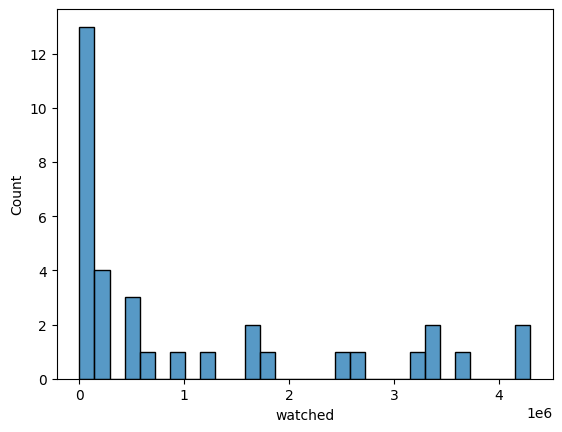

In [113]:
sns.histplot(x=df_films[df_films["actors"].apply(lambda x: "Leonardo DiCaprio" in x)]["watched"], bins=30)

<Axes: xlabel='watched', ylabel='Count'>

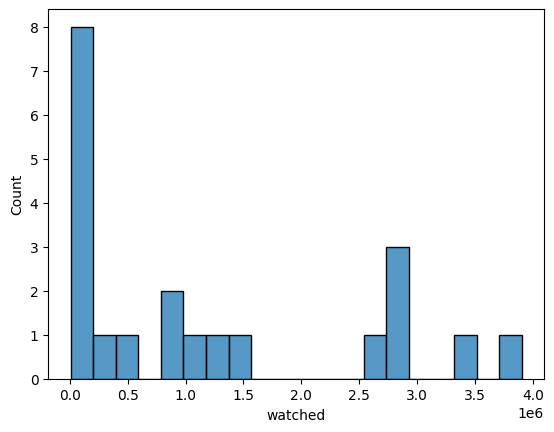

In [114]:
sns.histplot(x=df_films[df_films["actors"].apply(lambda x: "Timothée Chalamet" in x)]["watched"], bins=20)

In [115]:
#Actors with the highest rating with more then 10 films
actors[actors["count_films"]>10].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
actor,,,,,
Jimin,9454.545455,11,2024,2018,9.225455
Yui Ishikawa,91984.615385,13,2024,2013,8.500769
Marina Inoue,40141.666667,12,2024,2008,8.292500
Hiro Shimono,47873.333333,15,2024,2013,8.048667
Koki Uchiyama,47336.363636,11,2024,2015,8.028182
Yoshimasa Hosoya,26000.000000,26,2024,2013,7.994615
Setsuko Hara,35380.000000,12,1961,1936,7.921000
Kuniko Miyake,39790.909091,11,1968,1941,7.861818
Una Stubbs,76421.428571,14,2017,1983,7.846429


In [116]:
#Actors with the highest rating with more then 20 films
actors[actors["count_films"]>20].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
actor,,,,,
Yoshimasa Hosoya,26000.000000,26,2024,2013,7.994615
Tatsuya Nakadai,45225.000000,29,2014,1957,7.818571
Kamal Haasan,10614.285714,23,2024,1982,7.686500
Gian Maria Volonté,42452.789474,21,1981,1961,7.623000
Erland Josephson,34612.500000,25,2006,1950,7.618333
Yves Montand,18915.789474,21,1986,1946,7.573500
Chishū Ryū,22067.741935,35,1990,1929,7.552258
Taiji Tonoyama,17016.157895,21,1988,1947,7.494444
Gunnar Björnstrand,73800.000000,21,1984,1944,7.493810


In [117]:
actors[(actors["count_films"]>20) & (actors["debute"]<2010)].sort_values(by="mean_rating", ascending=False).head(10)

,watched_mean,count_films,last_film,debute,mean_rating
actor,,,,,
Tatsuya Nakadai,45225.000000,29,2014,1957,7.818571
Kamal Haasan,10614.285714,23,2024,1982,7.686500
Gian Maria Volonté,42452.789474,21,1981,1961,7.623000
Erland Josephson,34612.500000,25,2006,1950,7.618333
Yves Montand,18915.789474,21,1986,1946,7.573500
Chishū Ryū,22067.741935,35,1990,1929,7.552258
Taiji Tonoyama,17016.157895,21,1988,1947,7.494444
Gunnar Björnstrand,73800.000000,21,1984,1944,7.493810
Kei Satō,20995.954545,23,1999,1959,7.456190


#### Directors and actors

In [118]:
directors_act_duets = get_crew_duets(df_films_actors, "director", "actor")

In [119]:
directors_act_duets.head()

,director,actor,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
161,A.R. Murugadoss,Vijay,3,6.793333,7.99,11666.666667,14000.0,2018,2012,Thuppakki
214,Aanand L. Rai,Mohammed Zeeshan Ayyub,3,5.813333,6.77,12966.666667,17000.0,2018,2013,Raanjhanaa
218,Aanand L. Rai,R. Madhavan,3,5.603333,6.43,10500.000000,13000.0,2018,2011,Zero
228,Aanand L. Rai,Swara Bhasker,3,6.446667,6.77,11833.333333,17000.0,2015,2011,Raanjhanaa
368,Aaron Moorhead,Shane Brady,3,6.543333,6.91,69666.666667,98000.0,2019,2014,The Endless


In [120]:
#Most productive cinematogrophists
directors_act_duets.sort_values(by="count_films", ascending=False).head(10)

,director,actor,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
249891,Woody Allen,Woody Allen,28,6.789643,7.90,66703.571429,454000.0,2016,1966,Annie Hall
43312,Clint Eastwood,Clint Eastwood,24,6.738750,8.20,103775.000000,595000.0,2021,1971,Gran Torino
250852,Yasujirō Ozu,Chishū Ryū,23,7.474348,8.64,22721.739130,173000.0,1962,1929,Tokyo Story
135060,Kunihiko Yuyama,Rica Matsumoto,21,5.935000,7.05,37042.857143,203000.0,2017,1998,Pokémon: The First Movie
135038,Kunihiko Yuyama,Ikue Otani,21,5.935000,7.05,37042.857143,203000.0,2017,1998,Pokémon: The First Movie
135054,Kunihiko Yuyama,Megumi Hayashibara,20,5.969474,7.05,38245.000000,203000.0,2017,1998,Pokémon: The First Movie
135039,Kunihiko Yuyama,Inuko Inuyama,20,5.969474,7.05,38245.000000,203000.0,2017,1998,Pokémon: The First Movie
135063,Kunihiko Yuyama,Shin-ichiro Miki,19,5.931111,7.05,38731.578947,203000.0,2017,1998,Pokémon: The First Movie
3951,Akira Kurosawa,Takashi Shimura,18,7.672778,9.01,99477.777778,472000.0,1963,1943,Seven Samurai
116794,Johnnie To,Lam Suet,17,7.224706,7.95,7582.352941,20000.0,2016,1997,Drug War


In [121]:
#Cinematogrophists with the highest rating with more then 10 films
directors_act_duets[directors_act_duets["count_films"]>10].sort_values(by="rating_mean", ascending=False).head(10)

,director,actor,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
3966,Akira Kurosawa,Toshirō Mifune,16,7.896250,9.01,101418.750000,472000.0,1965,1948,Seven Samurai
212795,Satyajit Ray,Soumitra Chatterjee,12,7.697500,8.67,7958.333333,35000.0,1989,1959,Apur Sansar
91621,Ingmar Bergman,Erland Josephson,14,7.692143,8.73,39950.000000,133000.0,2003,1950,Autumn Sonata
177404,Orson Welles,Orson Welles,13,7.684615,8.22,103576.923077,809000.0,2020,1941,Citizen Kane
3951,Akira Kurosawa,Takashi Shimura,18,7.672778,9.01,99477.777778,472000.0,1963,1943,Seven Samurai
91643,Ingmar Bergman,Gunnar Björnstrand,17,7.651176,8.73,90441.176471,463000.0,1984,1948,Persona
239843,Tsai Ming-liang,Lee Kang-sheng,12,7.590833,8.04,19966.666667,53000.0,2024,1992,"Goodbye, Dragon Inn"
250852,Yasujirō Ozu,Chishū Ryū,23,7.474348,8.64,22721.739130,173000.0,1962,1929,Tokyo Story
246264,Werner Herzog,Werner Herzog,17,7.301765,8.24,16617.647059,44000.0,2022,1993,Cave of Forgotten Dreams
112598,John Ford,Ward Bond,13,7.271538,8.10,26076.923077,161000.0,1957,1940,The Searchers


In [122]:
#cinematogrophists with the highest number of views with more then 10 films
directors_act_duets[directors_act_duets["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(10)

,director,actor,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
129713,Kenneth Branagh,Kenneth Branagh,12,6.214167,7.43,162741.666667,731000.0,2023,1989,Murder on the Orient Express
43312,Clint Eastwood,Clint Eastwood,24,6.738750,8.20,103775.000000,595000.0,2021,1971,Gran Torino
177404,Orson Welles,Orson Welles,13,7.684615,8.22,103576.923077,809000.0,2020,1941,Citizen Kane
3966,Akira Kurosawa,Toshirō Mifune,16,7.896250,9.01,101418.750000,472000.0,1965,1948,Seven Samurai
3951,Akira Kurosawa,Takashi Shimura,18,7.672778,9.01,99477.777778,472000.0,1963,1943,Seven Samurai
91643,Ingmar Bergman,Gunnar Björnstrand,17,7.651176,8.73,90441.176471,463000.0,1984,1948,Persona
249891,Woody Allen,Woody Allen,28,6.789643,7.90,66703.571429,454000.0,2016,1966,Annie Hall
249777,Woody Allen,Mia Farrow,12,7.186667,7.90,47416.666667,116000.0,1992,1982,Hannah and Her Sisters
112489,John Ford,John Wayne,13,7.267692,8.32,41592.307692,161000.0,1963,1939,The Searchers
91621,Ingmar Bergman,Erland Josephson,14,7.692143,8.73,39950.000000,133000.0,2003,1950,Autumn Sonata


In [123]:
directors_act_duets["career_span"] = directors_act_duets["year_max"] - directors_act_duets["year_min"]
directors_act_duets.sort_values(by="career_span", ascending=False).head(10)

,director,actor,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film,career_span
177404,Orson Welles,Orson Welles,13,7.684615,8.22,1.035769e+05,809000.0,2020,1941,Citizen Kane,79
102625,Jean-Luc Godard,Jean-Luc Godard,13,7.054615,7.72,2.156154e+04,127000.0,2018,1963,Contempt,55
215219,Sergei Eisenstein,Grigori Aleksandrov,3,7.730000,7.81,7.130000e+04,173000.0,1979,1925,Battleship Potemkin,54
91621,Ingmar Bergman,Erland Josephson,14,7.692143,8.73,3.995000e+04,133000.0,2003,1950,Autumn Sonata,53
153191,Martin Scorsese,Harvey Keitel,6,7.443333,8.23,6.673333e+05,2400000.0,2019,1967,Taxi Driver,52
193265,Raúl Ruiz,Luis Alarcón,3,6.803333,7.22,2.200000e+03,2800.0,2020,1968,The Wandering Soap Opera,52
70864,Francis Ford Coppola,Talia Shire,4,7.437500,9.06,1.232250e+06,2700000.0,2024,1972,The Godfather,52
249891,Woody Allen,Woody Allen,28,6.789643,7.90,6.670357e+04,454000.0,2016,1966,Annie Hall,50
43312,Clint Eastwood,Clint Eastwood,24,6.738750,8.20,1.037750e+05,595000.0,2021,1971,Gran Torino,50
153326,Martin Scorsese,Robert De Niro,10,7.900000,8.86,9.232000e+05,2400000.0,2023,1973,Taxi Driver,50


#### Actor and actor duets

In [163]:
df_exp = df_films_actors[["actor", "name"]]
df_exp = df_exp.dropna()
df_pairs = df_exp.merge(df_exp, on="name")
df_pairs['actor_1'] = df_pairs[['actor_x', 'actor_y']].min(axis=1)
df_pairs['actor_2'] = df_pairs[['actor_x', 'actor_y']].max(axis=1)
df_pairs = df_pairs[df_pairs["actor_x"] != df_pairs["actor_y"]]
df_pairs = df_pairs.merge(df_films[["name", "watched", "rating", "year"]], on="name")
df_pairs = df_pairs.drop(columns=["actor_x", "actor_y"])
df_pairs = df_pairs.drop_duplicates()
df_pairs.sort_values(by=['actor_1', 'actor_2']).head()


,name,actor_1,actor_2,watched,rating,year
2440010,"Good Day, Ramon",Jorge de los Reyes,Adriana Barraza,3700.0,7.04,2013
2440055,"Good Day, Ramon",Jorge de los Reyes,Andreas Berg,3700.0,7.04,2013
2440019,"Good Day, Ramon",Jorge de los Reyes,Arcelia Ramírez,3700.0,7.04,2013
2440037,"Good Day, Ramon",Jorge de los Reyes,Hector Kotsifakis,3700.0,7.04,2013
2440001,"Good Day, Ramon",Jorge de los Reyes,Ingeborg Schöner,3700.0,7.04,2013


In [164]:
actor_duets = get_crew_duets(df_pairs, "actor_1", "actor_2")
actor_duets.head()

,actor_1,actor_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
186,2 Chainz,Aaron Cohen,4,5.87,6.54,11500.0,35000.0,2022,1951,The Enforcer
187,2 Chainz,Adelaide Klein,4,5.87,6.54,11500.0,35000.0,2022,1951,The Enforcer
188,2 Chainz,Alexis Ren,4,5.87,6.54,11500.0,35000.0,2022,1951,The Enforcer
189,2 Chainz,Anita Mui,4,5.87,6.54,11500.0,35000.0,2022,1951,The Enforcer
190,2 Chainz,Antonio Banderas,4,5.87,6.54,11500.0,35000.0,2022,1951,The Enforcer


In [167]:
#Most countess duets of actors
actor_duets.sort_values(by="count_films", ascending=False).head(10)

,actor_1,actor_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
830284,Ikue Otani,Megumi Hayashibara,33,6.291875,7.91,27166.666667,203000.0,2020,1998,Pokémon: The First Movie
692368,Frank Welker,Grey DeLisle,32,6.426875,7.83,23481.250000,109000.0,2023,2001,"Batman: The Dark Knight Returns, Part 2"
830303,Ikue Otani,Rica Matsumoto,26,5.889200,7.05,32765.384615,203000.0,2022,1998,Pokémon: The First Movie
830250,Ikue Otani,Inuko Inuyama,24,5.952609,7.05,34795.833333,203000.0,2020,1998,Pokémon: The First Movie
835712,Inuko Inuyama,Megumi Hayashibara,24,5.952609,7.05,34795.833333,203000.0,2020,1998,Pokémon: The First Movie
830313,Ikue Otani,Shin-ichiro Miki,24,5.940000,7.05,33766.666667,203000.0,2020,1998,Pokémon: The First Movie
1193513,Megumi Hayashibara,Rica Matsumoto,24,5.952609,7.05,34795.833333,203000.0,2020,1998,Pokémon: The First Movie
835721,Inuko Inuyama,Rica Matsumoto,24,5.952609,7.05,34795.833333,203000.0,2020,1998,Pokémon: The First Movie
1019176,Kappei Yamaguchi,Minami Takayama,23,7.025217,8.32,62804.347826,1300000.0,2024,1989,Kiki’s Delivery Service
692500,Frank Welker,Matthew Lillard,23,6.313043,7.34,13234.782609,37000.0,2023,2010,Scooby-Doo! Camp Scare


Mostly it is voice actors

In [168]:
#Cinematogrophists with the highest rating with more then 10 films
actor_duets[actor_duets["count_films"]>10].sort_values(by="rating_mean", ascending=False).head(10)

,actor_1,actor_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
1372532,Yoshimasa Hosoya,Yuki Kaji,11,8.538182,9.23,43800.000000,79000.0,2024,2014,HAIKYU!! The Dumpster Battle
1162381,Marina Inoue,Yuki Kaji,11,8.176364,9.23,43136.363636,78000.0,2024,2005,Attack on Titan: Chronicle
1124799,Louise Brealey,Rupert Graves,11,7.958182,8.79,83727.272727,167000.0,2017,2010,Sherlock: The Abominable Bride
246184,Benedict Cumberbatch,Rupert Graves,12,7.925000,8.79,82833.333333,167000.0,2017,2010,Sherlock: The Abominable Bride
1172060,Martin Freeman,Rupert Graves,12,7.925000,8.79,82833.333333,167000.0,2017,2010,Sherlock: The Abominable Bride
1324833,Rupert Graves,Una Stubbs,12,7.925000,8.79,82833.333333,167000.0,2017,2010,Sherlock: The Abominable Bride
727263,George Harrison,Ringo Starr,11,7.923636,9.03,39836.363636,148000.0,2024,1964,A Hard Day’s Night
246089,Benedict Cumberbatch,Louise Brealey,12,7.905833,8.79,82750.000000,167000.0,2017,2010,Sherlock: The Abominable Bride
1124808,Louise Brealey,Una Stubbs,12,7.905833,8.79,82750.000000,167000.0,2017,2010,Sherlock: The Abominable Bride
1124795,Louise Brealey,Martin Freeman,12,7.905833,8.79,82750.000000,167000.0,2017,2010,Sherlock: The Abominable Bride


In [169]:
#Cinematogrophists with the highest rating with more then 15 films
actor_duets[actor_duets["count_films"]>15].sort_values(by="rating_mean", ascending=False).head(10)

,actor_1,actor_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
1357962,Takashi Shimura,Toshirō Mifune,18,7.710000,9.01,88638.888889,472000.0,1989,1947,Seven Samurai
1029117,Kathleen Barr,Kelly Sheridan,19,7.352632,8.24,132842.105263,295000.0,2014,2001,Barbie as The Princess & the Pauper
1019144,Kappei Yamaguchi,Kenichi Ogata,16,7.128125,7.91,7312.500000,12000.0,2019,1997,Detective Conan: The Time Bombed Skyscraper
1019176,Kappei Yamaguchi,Minami Takayama,23,7.025217,8.32,62804.347826,1300000.0,2024,1989,Kiki’s Delivery Service
1219837,Minami Takayama,Wakana Yamazaki,22,7.007727,7.91,6645.454545,12000.0,2024,1997,Detective Conan: The Time Bombed Skyscraper
1019217,Kappei Yamaguchi,Wakana Yamazaki,21,6.994762,7.91,6676.190476,12000.0,2024,1997,Detective Conan: The Time Bombed Skyscraper
830257,Ikue Otani,Kappei Yamaguchi,23,6.952174,8.08,14791.304348,69000.0,2022,1997,One Piece Film Red
1035935,Kazuya Nakai,Mayumi Tanaka,16,6.774375,8.40,19793.750000,69000.0,2024,2001,One Piece Film Red
692520,Frank Welker,Mindy Cohn,18,6.533889,7.34,23722.222222,51000.0,2015,2004,Scooby-Doo! and the Loch Ness Monster
761299,Grey DeLisle,Mindy Cohn,18,6.533889,7.34,23722.222222,51000.0,2015,2004,Scooby-Doo! and the Loch Ness Monster


In [171]:
#actor duets with the highest number of views with more then 10 films
actor_duets[actor_duets["count_films"]>10].sort_values(by="watched_mean", ascending=False).head(20)

,actor_1,actor_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
48677,Alan Rickman,Robbie Coltrane,11,7.227273,8.30,1.695182e+06,3600000.0,2010,1933,Harry Potter and the Philosopher’s Stone
48524,Alan Rickman,Helena Bonham Carter,13,6.997692,8.55,9.381769e+05,2800000.0,2016,1933,Harry Potter and the Order of the Phoenix
48730,Alan Rickman,Timothy Spall,11,6.932727,8.55,6.723909e+05,3500000.0,2016,1933,Harry Potter and the Prisoner of Azkaban
796328,Helena Bonham Carter,Johnny Depp,14,6.698571,8.55,6.396643e+05,2500000.0,2016,1933,Charlie and the Chocolate Factory
796501,Helena Bonham Carter,Robbie Coltrane,11,6.761818,7.57,5.126909e+05,2800000.0,2012,1933,Harry Potter and the Order of the Phoenix
156192,Anne Hathaway,Helena Bonham Carter,12,6.849167,7.57,4.348583e+05,1800000.0,2019,1933,Alice in Wonderland
796567,Helena Bonham Carter,Timothy Spall,11,6.854545,8.55,4.212091e+05,1800000.0,2016,1933,Alice in Wonderland
796585,Helena Bonham Carter,Verna Felton,11,6.492727,7.60,4.060455e+05,1800000.0,2021,1933,Alice in Wonderland
1368787,Verna Felton,Whoopi Goldberg,11,6.492727,7.60,4.060455e+05,1800000.0,2021,1933,Alice in Wonderland
796595,Helena Bonham Carter,Whoopi Goldberg,11,6.492727,7.60,4.060455e+05,1800000.0,2021,1933,Alice in Wonderland


In [172]:
actor_duets["career_span"] = actor_duets["year_max"] - actor_duets["year_min"]
actor_duets.sort_values(by="career_span", ascending=False).head(10)

,actor_1,actor_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film,career_span
747937,Glenn Close,Sam Shepard,12,6.844167,8.72,34000.000000,275000.0,2024,1921,Brothers,103
1346902,Simon McBurney,Willem Dafoe,6,5.855000,7.67,438550.000000,2100000.0,2024,1922,Nosferatu,102
651040,Esom,Seo Hyun-woo,4,6.710000,7.13,4850.000000,7800.0,2024,1922,Escape,102
70038,Alexander Granach,Gustav von Wangenheim,3,7.253333,7.67,869033.333333,2100000.0,2024,1922,Nosferatu,102
651043,Esom,Sul Kyung-gu,3,6.826667,7.05,18766.666667,50000.0,2023,1922,Kill Boksoon,101
1339048,Seo Hyun-woo,Sul Kyung-gu,5,7.418000,8.47,10780.000000,38000.0,2023,1922,Hope,101
651011,Esom,Kim Jong-soo,3,6.720000,6.73,3300.000000,3600.0,2023,1922,Samjin Company English Class,101
651038,Esom,Park So-dam,3,6.203333,6.72,3100.000000,3300.0,2023,1922,Phantom,101
329904,Bárbara Lennie,Eduard Fernández,7,6.682857,8.21,108157.142857,417000.0,2022,1921,The Skin I Live In,101
78225,Alfred Abel,Grete Berger,4,7.302500,8.34,98325.000000,347000.0,2023,1922,Metropolis,101


### Genres

In [191]:
cnt_empty_list_feature(df_films, "genres")

Count of empty lists: 13 objects 
0.04% in dataset


In [194]:
df_films[df_films["genres"].apply(lambda x: len(x) == 0)].sort_values(by="watched", ascending=False).head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade
9435,Cunk on Earth,2022,Follows Philomena Cunk as she comically tells ...,19.0,26.0,25.0,85.0,149.0,825.0,1644.0,5868.0,3056.0,7715.0,8.72,30000.0,...,[this has almost as much cultural significance...,None,150.0,[Diane Morgan],Christian Watt,Charlie Brooker,None,None,None,[],[],[],[],https://letterboxd.com/film/cunk-on-earth/,2020
20249,Neşeli Günler,1978,Years after a divorce divides their family in ...,10.0,21.0,27.0,105.0,196.0,1064.0,1325.0,2505.0,586.0,1229.0,7.75,21000.0,...,"[Like Marriage Story but stronger, Sen seversi...",None,95.0,"[Münir Özkul, Adile Naşit, Şener Şen, Mürüvvet...",Orhan Aksoy,Sadık Şendil,Ertem Eğilmez,Erdoğan Engin,Melih Kibar,[Arzu Film],[Turkey],[],[],https://letterboxd.com/film/neseli-gunler/,1970
11003,Shrek Retold,2018,After his swamp is filled with magical creatur...,88.0,128.0,103.0,291.0,429.0,1532.0,1667.0,2548.0,708.0,2612.0,7.69,17000.0,...,"[Proof that communism works., Glad this exists...",We got over 200 people to remake Shrek. This i...,90.0,"[Grant Duffrin, Noah Munck, Harry Antonucci, A...",Grant Duffrin,Jacy Catlin,Justin Silverman,None,Christopher Carlone,[3GI Industries],[USA],[],[],https://letterboxd.com/film/shrek-retold/,2010
20452,Halo 4: Forward Unto Dawn,2012,UNSC Cadet Thomas Lasky must conquer his inner...,103.0,285.0,339.0,942.0,1159.0,2066.0,1234.0,853.0,171.0,237.0,5.82,12000.0,...,"[Starts a bit slow, but once the Master Chief ...",The story of Halo 4 begins at dawn.,75.0,"[Thom Green, Anna Popplewell, Darren O'Hare, J...",Stewart Hendler,None,Hameed Shaukat,Brett Pawlak,Neil Davidge,"[Microsoft Studios, 343 Industries, Laskey Pro...",[USA],[],"[Monsters, aliens, sci-fi and the apocalypse, ...",https://letterboxd.com/film/halo-4-forward-unt...,2010
22142,Green Bones,2024,A soon-to-be released criminal and a correctio...,5.0,14.0,13.0,61.0,104.0,461.0,753.0,1363.0,769.0,823.0,8.00,4800.0,...,[Na-distract ako sa utong ni Wendell Ramos. Pa...,None,100.0,"[Dennis Trillo, Ruru Madrid, Iza Calzado, Ales...",Zig Madamba Dulay,Ricardo Lee,Nessa S. Valdellon,Neil Daza,Len Calvo,"[GMA Pictures, GMA Public Affairs, Brightburn ...",[Philippines],[],[],https://letterboxd.com/film/green-bones/,2020


In [196]:
df_films["cnt_genres"] = df_films.apply(lambda row: len(row["genres"]), axis=1)
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade,cnt_genres
2481,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,6.22,160000.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3
15396,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,5.55,20000.0,...,None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5
32795,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,7.47,3800.0,...,None,90.0,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Switzerland, Turkey, France, Germany]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3
19980,Love & Human Remains,1993,"In a Canadian metropolis, failed actor David s...",7.0,28.0,38.0,151.0,203.0,551.0,556.0,532.0,178.0,289.0,7.00,3500.0,...,Welcome to love in the 90’s,100.0,"[Thomas Gibson, Ruth Marshall, Cameron Bancrof...",Denys Arcand,Brad Fraser,Roger Frappier,Paul Sarossy,John McCarthy,"[Atlantis Films, First Choice Films, The Ontar...",[Canada],"[Drama, Comedy]",[],https://letterboxd.com/film/love-human-remains/,1990,2
28173,Night of the Demons III,1997,When a group of rambunctious teens take refuge...,65.0,170.0,228.0,578.0,455.0,493.0,132.0,76.0,8.0,49.0,4.76,3200.0,...,Angela is back and she’s ready to party down… ...,85.0,"[Larry Day, Amelia Kinkade, Kristen Holden-Rie...",Jim Kaufman,Kevin Tenney,Claudio Castravelli,Walter Bal,Raymond C. Fabi,"[Flanders Productions, Fries/Schultz Film Group]","[Canada, USA]","[Comedy, Horror]","[Horror, the undead and monster classics, Gory...",https://letterboxd.com/film/night-of-the-demon...,1990,2


In [198]:
df_films["cnt_genres"].unique()

array([3, 5, 2, 1, 4, 6, 8, 0, 7, 9])

<Axes: xlabel='cnt_genres', ylabel='count'>

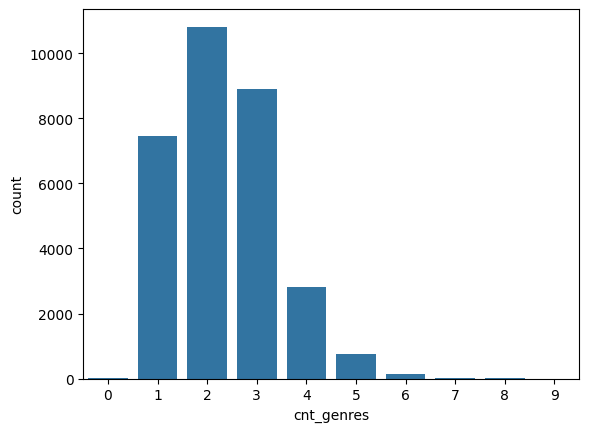

In [199]:
sns.countplot(data=df_films, x="cnt_genres")

<Axes: xlabel='cnt_genres', ylabel='count'>

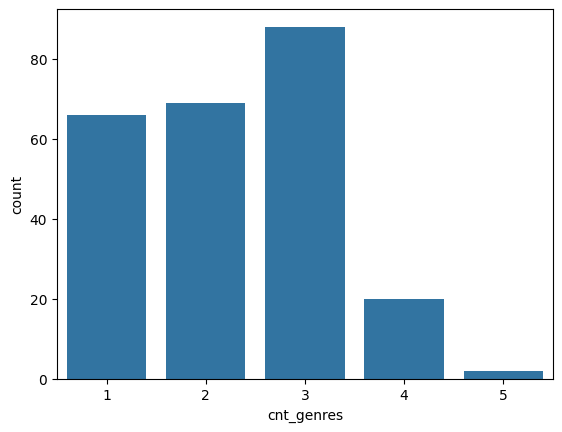

In [210]:
sns.countplot(data=df_films[df_films["top"].notna()], x="cnt_genres")

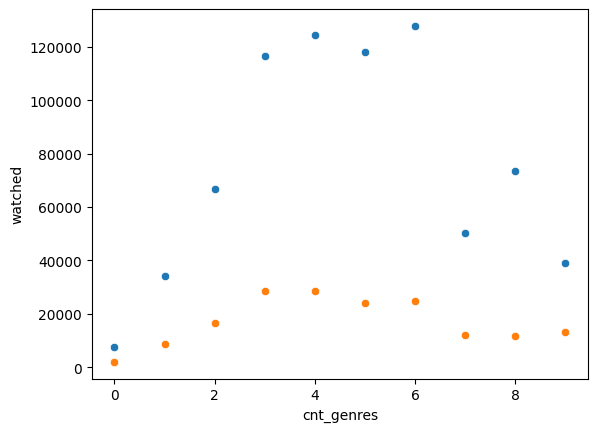

In [209]:
sns.scatterplot(data=df_films.groupby(by="cnt_genres")["watched"].mean().reset_index(), x="cnt_genres", y="watched")
sns.scatterplot(data=df_films.groupby(by="cnt_genres")["liked"].mean().reset_index(), x="cnt_genres", y="liked")
plt.show()

________________________________________________________________________________________________________________________

In [215]:
df_genres = pd.merge(df_films["genres"].explode().reset_index(), df_films.reset_index(), on="index", how="left")
df_genres = df_genres.drop(columns=["genres_y"])
df_genres = df_genres.rename(columns={"genres_x": "genre"})
df_genres.head()

,index,genre,name,year,description,1,2,3,4,5,6,7,8,9,10,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,themes,link,decade,cnt_genres
0,2481,Mystery,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3
1,2481,Horror,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3
2,2481,Thriller,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,[My father is in the early stages of Alzheimer...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3
3,15396,Horror,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,...,"[Mickey Rooney as Movie Mason and his ""Magic a...",None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5
4,15396,Family,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,...,"[Mickey Rooney as Movie Mason and his ""Magic a...",None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5


In [218]:
df_genres["genre"].nunique()

19

In [219]:
df_genres["genre"].unique()

array(['Mystery', 'Horror', 'Thriller', 'Family', 'Action', 'Comedy',
       'Drama', 'Romance', 'Crime', 'Science Fiction', 'Adventure',
       'Western', 'Documentary', 'Fantasy', 'Music', 'Animation',
       'TV Movie', 'History', 'War', nan], dtype=object)

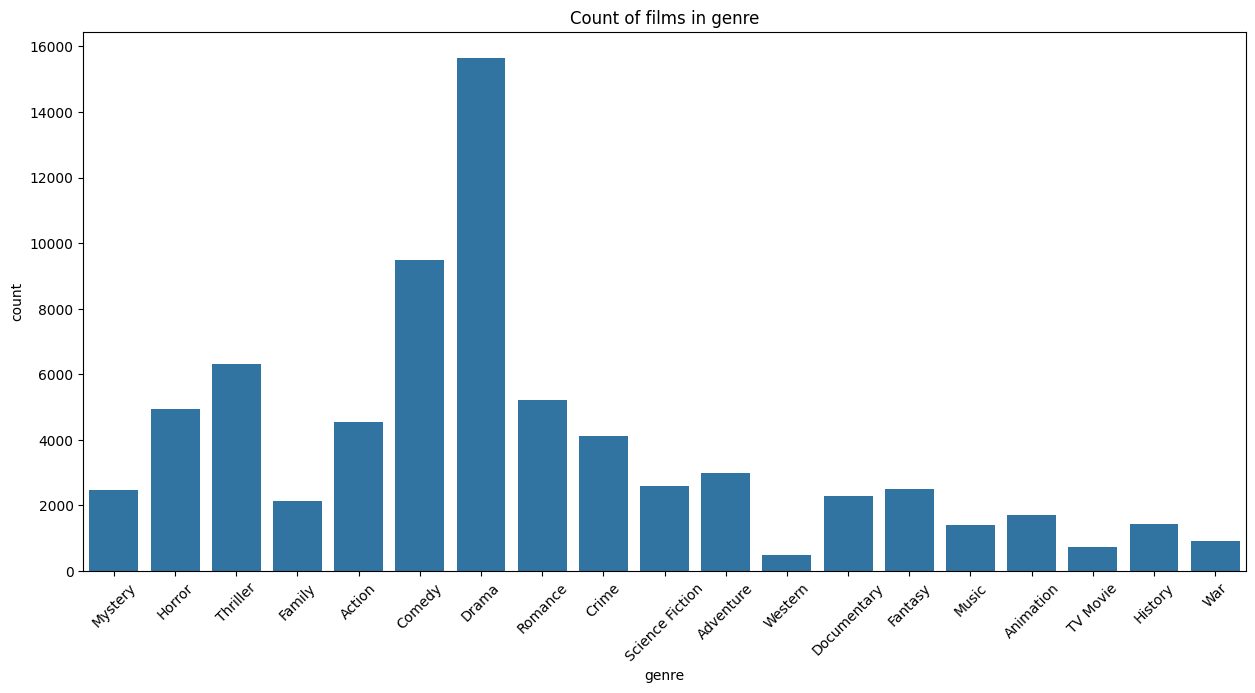

In [221]:
plt.figure(figsize=(15, 7))
sns.countplot(data=df_genres, x="genre")
plt.xticks(rotation=45)
plt.title("Count of films in genre")
plt.show()

In [222]:
df_genres[df_genres["genre"] == "Music"].sort_values(by="watched", ascending=False).head()

,index,genre,name,year,description,1,2,3,4,5,6,7,8,9,10,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,themes,link,decade,cnt_genres
35858,4,Music,La La Land,2016,"Mia, an aspiring actress, serves lattes to mov...",14471.0,44167.0,15291.0,106473.0,61872.0,318154.0,247374.0,760376.0,404405.0,1247646.0,...,[this cured my depression and brought it back ...,Here’s to the fools who dream.,129.0,"[Ryan Gosling, Emma Stone, John Legend, Rosema...",Damien Chazelle,Damien Chazelle,Jordan Horowitz,Linus Sandgren,Justin Hurwitz,"[Summit Entertainment, Gilbert Films, Impostor...",[USA],"[Song and dance, Humanity and the world around...",https://letterboxd.com/film/la-la-land/,2010,4
20076,7,Music,Whiplash,2014,"Under the direction of a ruthless instructor, ...",3010.0,7390.0,3695.0,24414.0,21412.0,146377.0,182441.0,749412.0,552858.0,1272729.0,...,[i had a dream that j.k. simmons yelled at me ...,The road to greatness can take you to the edge.,107.0,"[Miles Teller, J.K. Simmons, Paul Reiser, Meli...",Damien Chazelle,Damien Chazelle,Jason Blum,Sharone Meir,Justin Hurwitz,"[Bold Films, Blumhouse Productions, Right of W...",[USA],"[Moving relationship stories, Student coming-o...",https://letterboxd.com/film/whiplash-2014/,2010,2
19078,83,Music,Coco,2017,Despite his family’s baffling generations-old ...,2639.0,7574.0,4856.0,33720.0,33805.0,210128.0,213020.0,624991.0,261119.0,647450.0,...,"[A story about death, murder, loss, grief, agi...",The celebration of a lifetime.,105.0,"[Anthony Gonzalez, Gael García Bernal, Benjami...",Lee Unkrich,Adrian Molina,Darla K. Anderson,Matt Aspbury,Michael Giacchino,"[Pixar, Walt Disney Pictures]",[USA],"[Song and dance, Moving relationship stories, ...",https://letterboxd.com/film/coco-2017/,2010,4
60144,211,Music,Bohemian Rhapsody,2018,"Singer Freddie Mercury, guitarist Brian May, d...",12994.0,30094.0,26624.0,90784.0,89394.0,264022.0,223543.0,348889.0,95395.0,214153.0,...,"[1""How many times do we need to teach you this...",Fearless lives forever,135.0,"[Rami Malek, Gwilym Lee, Ben Hardy, Joseph Maz...",Bryan Singer,Anthony McCarten,Jim Beach,Newton Thomas Sigel,None,"[20th Century Fox, Regency Enterprises, GK Fil...","[UK, USA]","[Moving relationship stories, Song and dance, ...",https://letterboxd.com/film/bohemian-rhapsody/,2010,2
50553,411,Music,School of Rock,2003,"Fired from his band and hard up for cash, guit...",1996.0,6206.0,4978.0,28065.0,33010.0,155347.0,157024.0,251340.0,71419.0,148873.0,...,"[Why did I cry?, i pledge allegiance 🤝😌 to the...",He just landed the gig of his life: 5th grade.,110.0,"[Jack Black, Joan Cusack, Mike White, Sarah Si...",Richard Linklater,Mike White,Scott Rudin,Rogier Stoffers,Craig Wedren,"[Paramount Pictures, Scott Rudin Productions]",[USA],"[Crude humor and satire, Song and dance, Catch...",https://letterboxd.com/film/school-of-rock/,2000,2


In [223]:
df_genres[df_genres["genre"] == "Documentary"].sort_values(by="watched", ascending=False).head()

,index,genre,name,year,description,1,2,3,4,5,6,7,8,9,10,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,themes,link,decade,cnt_genres
15742,2429,Documentary,Jackass: The Movie,2002,Johnny Knoxville and his band of maniacs perfo...,1579.0,3161.0,2185.0,8810.0,10476.0,40152.0,30612.0,33474.0,5921.0,14641.0,...,[jackass is the only positive byproduct of mas...,Do not attempt this at home.,85.0,"[Johnny Knoxville, Bam Margera, Steve-O, Chris...",Jeff Tremaine,Jeff Tremaine,Johnny Knoxville,Dimitry Elyashkevich,Sam Spiegel,"[Lynch Siderow Productions, Dickhouse Producti...",[USA],"[Crude humor and satire, Funny jokes and crude...",https://letterboxd.com/film/jackass-the-movie/,2000,3
52423,1685,Documentary,Jackass Forever,2022,"The Jackass crew, along with some newcomers, r...",1375.0,2503.0,1920.0,8188.0,10127.0,38027.0,41108.0,63353.0,13120.0,20779.0,...,"[knoxville with silver hair…unspeakably hot, I...",Some people never learn.,96.0,"[Johnny Knoxville, Steve-O, Chris Pontius, Dav...",Jeff Tremaine,Nick Kreiss,Jason Baum,Lance Bangs,Joseph Shirley,"[Paramount Pictures, MTV Entertainment Studios...",[USA],"[Crude humor and satire, Funny jokes and crude...",https://letterboxd.com/film/jackass-forever/,2020,3
71433,2129,Documentary,The Social Dilemma,2020,This documentary-drama hybrid explores the dan...,1980.0,4140.0,3828.0,13215.0,15624.0,42493.0,31774.0,33967.0,6286.0,10000.0,...,[It has really good insight but could go witho...,The technology that connects us also controls us.,94.0,"[Tristan Harris, Jeff Seibert, Bailey Richards...",Jeff Orlowski,Davis Coombe,Larissa Rhodes,John Behrens,Mark A. Crawford,"[Exposure Labs, Argent Pictures, The Space Pro...",[USA],"[Intense violence and sexual transgression, Hu...",https://letterboxd.com/film/the-social-dilemma/,2020,2
17653,2141,Documentary,Harry Potter 20th Anniversary: Return to Hogwarts,2022,An enchanting making-of story told through all...,667.0,1353.0,895.0,4712.0,5292.0,23470.0,19270.0,43696.0,11596.0,39343.0,...,[jk rowling in this is the awful grandma you n...,Welcome back to where the magic began.,103.0,"[Daniel Radcliffe, Rupert Grint, Emma Watson, ...",Joe Pearlman,None,Mike Darnell,Edgar Dubrovsky,Charlie Mole,"[Pulse Films, Warner Horizon Unscripted Televi...","[UK, USA]",[],https://letterboxd.com/film/harry-potter-20th-...,2020,1
33426,1884,Documentary,Free Solo,2018,Follow Alex Honnold as he attempts to become t...,170.0,405.0,399.0,2067.0,3229.0,18019.0,30950.0,72300.0,26087.0,25935.0,...,[a great movie about how annoying it is to dat...,Live beyond fear.,100.0,"[Alex Honnold, Tommy Caldwell, Jimmy Chin, San...",Jimmy Chin,None,Vicky Du,Jimmy Chin,Marco Beltrami,"[National Geographic Documentary Films, Little...",[USA],"[Moving relationship stories, Touching and sen...",https://letterboxd.com/film/free-solo/,2010,2


In [228]:
df_genres[df_genres["genre"] == "Documentary"]["name"].count()

np.int64(2298)

We will discover only (or approximatly  only) feature films, so better to remove documentary films

In [225]:
df_genres[df_genres["genre"] == "TV Movie"].sort_values(by="watched", ascending=False).head()

,index,genre,name,year,description,1,2,3,4,5,6,7,8,9,10,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,themes,link,decade,cnt_genres
52389,764,TV Movie,High School Musical,2006,A popular high school athlete and an academica...,8710.0,18595.0,12598.0,46684.0,41768.0,123079.0,67741.0,94396.0,18454.0,83802.0,...,"[Sharpay should’ve just killed them fr, this >...",Long live the fighters.,98.0,"[Zac Efron, Vanessa Hudgens, Ashley Tisdale, L...",Kenny Ortega,Peter Barsocchini,Don Schain,Gordon Lonsdale,David Lawrence,"[Salty Pictures, First Street Films]",[USA],"[Song and dance, Underdogs and coming of age, ...",https://letterboxd.com/film/high-school-musical/,2000,6
46071,1071,TV Movie,High School Musical 2,2007,The East High Wildcats are gearing up for big ...,5863.0,13245.0,9877.0,35549.0,29749.0,78984.0,45826.0,67086.0,17329.0,65041.0,...,[the funniest subplot of this movie is how tro...,It’s time 2 celebrate!,108.0,"[Zac Efron, Vanessa Hudgens, Ashley Tisdale, L...",Kenny Ortega,Peter Barsocchini,Kenny Ortega,Daniel Aranyó,David Lawrence,"[First Street Films, Salty Pictures]",[USA],"[Song and dance, Dazzling vocal performances a...",https://letterboxd.com/film/high-school-musica...,2000,6
8453,1350,TV Movie,Black Mirror: Bandersnatch,2018,"In 1984, a young programmer begins to question...",3409.0,8545.0,7497.0,29185.0,32835.0,85232.0,65044.0,63050.0,13625.0,19902.0,...,[it's 90 minutes? tell that to me at 3 a.m. tr...,None,90.0,"[Fionn Whitehead, Craig Parkinson, Alice Lowe,...",David Slade,Charlie Brooker,Russell McLean,Jake Polonsky,Edgar Froese,[House of Tomorrow],[UK],"[Intense violence and sexual transgression, Dr...",https://letterboxd.com/film/black-mirror-bande...,2010,5
70218,1934,TV Movie,Camp Rock,2008,When Mitchie gets a chance to attend Camp Rock...,5966.0,13498.0,10587.0,31302.0,23760.0,47186.0,18607.0,24375.0,3803.0,19472.0,...,[C’MON GUYS I’VE LEARNED MY LESSON I SHOWERED ...,Don’t fit in. Stand out.,95.0,"[Demi Lovato, Joe Jonas, Meaghan Jette Martin,...",Matthew Diamond,Karin Gist,Kevin Lafferty,Dean Cundey,David Kitay,"[Alan Sacks Productions, Walt Disney Televisio...",[USA],"[Song and dance, Dazzling vocal performances a...",https://letterboxd.com/film/camp-rock/,2000,6
25535,2045,TV Movie,Lemonade Mouth,2011,When five ragtag freshman first meet in detent...,1274.0,3063.0,2736.0,9580.0,9819.0,30121.0,24147.0,38101.0,10425.0,42170.0,...,[This movie was important to the gay rights mo...,"Poets, geniuses, revolutionaries.",113.0,"[Bridgit Mendler, Adam Hicks, Hayley Kiyoko, N...",Patricia Riggen,April Blair,Matias Alvarez,Checco Varese,Christopher Lennertz,"[Martin Chase Productions, GWave Productions]",[USA],"[Song and dance, Dance rhythms and catchy tunes]",https://letterboxd.com/film/lemonade-mouth/,2010,4


In [226]:
df_genres[df_genres["genre"] == "History"].sort_values(by="watched", ascending=False).head()

,index,genre,name,year,description,1,2,3,4,5,6,7,8,9,10,...,popular_reviews,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,themes,link,decade,cnt_genres
14304,6,History,Oppenheimer,2023,The story of J. Robert Oppenheimer’s role in t...,6848.0,16656.0,9089.0,56983.0,51399.0,251270.0,273977.0,816169.0,578438.0,913387.0,...,"[watching this after i just watched barbie, ca...",The world forever changes.,181.0,"[Cillian Murphy, Emily Blunt, Matt Damon, Robe...",Christopher Nolan,Christopher Nolan,Christopher Nolan,Hoyte van Hoytema,Ludwig Göransson,"[Syncopy, Universal Pictures, Atlas Entertainm...","[UK, USA]","[Humanity and the world around us, Politics an...",https://letterboxd.com/film/oppenheimer-2023/,2020,2
39088,40,History,Little Women,2019,Four sisters come of age in America in the aft...,2500.0,7422.0,4621.0,31144.0,29349.0,176692.0,181319.0,548663.0,266863.0,765840.0,...,[laurie: we look like a couple jo: a couple of...,Own your story,135.0,"[Saoirse Ronan, Emma Watson, Florence Pugh, El...",Greta Gerwig,Greta Gerwig,Denise Di Novi,Yorick Le Saux,Alexandre Desplat,"[Columbia Pictures, Regency Enterprises, Pasca...",[USA],"[Moving relationship stories, Touching and sen...",https://letterboxd.com/film/little-women-2019/,2010,3
47224,125,History,1917,2019,"At the height of the First World War, two youn...",1380.0,4285.0,3370.0,20172.0,24384.0,134841.0,190343.0,522855.0,255002.0,325978.0,...,[“1917 makes you FEEL like you’re in the war” ...,Time is the enemy,119.0,"[George MacKay, Dean-Charles Chapman, Mark Str...",Sam Mendes,Krysty Wilson-Cairns,Pippa Harris,Roger Deakins,Thomas Newman,"[DreamWorks Pictures, Reliance Entertainment, ...","[India, Spain, UK, USA]","[War and historical adventure, Epic history an...",https://letterboxd.com/film/1917/,2010,4
29418,259,History,Saving Private Ryan,1998,"As U.S. troops storm the beaches of Normandy, ...",1379.0,3308.0,2323.0,12627.0,13992.0,77861.0,107680.0,330472.0,203612.0,285227.0,...,[Watched at a Midas auto repair shop (it was p...,The mission is a man.,169.0,"[Tom Hanks, Tom Sizemore, Edward Burns, Barry ...",Steven Spielberg,Robert Rodat,Steven Spielberg,Janusz Kamiński,John Williams,"[DreamWorks Pictures, Paramount Pictures, Ambl...",[USA],"[War and historical adventure, Epic history an...",https://letterboxd.com/film/saving-private-ryan/,1990,3
39345,186,History,Schindler’s List,1993,The true story of how businessman Oskar Schind...,1450.0,2224.0,1275.0,6727.0,6411.0,41278.0,52181.0,228150.0,186085.0,465858.0,...,[Probably the greatest movie I never want to s...,"Whoever saves one life, saves the world entire.",195.0,"[Liam Neeson, Ben Kingsley, Ralph Fiennes, Car...",Steven Spielberg,Steven Zaillian,Steven Spielberg,Janusz Kamiński,John Williams,[Amblin Entertainment],[USA],"[Humanity and the world around us, War and his...",https://letterboxd.com/film/schindlers-list/,1990,3


In [238]:
genres_intersaction = get_crew_duets(value_intersaction_on_set_feature(df_genres, "genre", df_films), "genre_1", "genre_2")
genres_intersaction.head()

,genre_1,genre_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
0,Action,Adventure,1452,6.023623,9.23,246403.466942,4400000.0,2024,1920,Spider-Man: Into the Spider-Verse
1,Action,Animation,466,6.574440,9.23,118864.062232,4400000.0,2024,1922,Spider-Man: Into the Spider-Verse
2,Action,Comedy,1156,6.076860,8.95,113322.468858,3800000.0,2024,1921,Everything Everywhere All at Once
3,Action,Crime,1370,6.297740,8.94,82273.654015,4500000.0,2024,1922,The Dark Knight
4,Action,Documentary,43,6.776047,8.51,67172.093023,527000.0,2023,1968,The King


In [243]:
genres_intersaction.sort_values(by="count_films", ascending=False).head(10)

,genre_1,genre_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
53,Comedy,Drama,3882,6.631436,9.44,71204.753478,5000000.0,2024,1920,Parasite
99,Drama,Romance,3862,6.632127,9.23,66826.083118,4400000.0,2024,1920,La La Land
102,Drama,Thriller,3269,6.384526,9.17,81439.676965,5100000.0,2024,1920,Fight Club
60,Comedy,Romance,2535,6.278129,9.23,82732.076134,4400000.0,2024,1921,La La Land
67,Crime,Drama,2442,6.676871,9.43,74352.731777,5000000.0,2024,1920,Joker
140,Horror,Thriller,2276,5.753860,9.05,86547.173111,5000000.0,2024,1920,Parasite
77,Crime,Thriller,2233,6.410676,8.95,80865.449172,5000000.0,2024,1920,Joker
15,Action,Thriller,1919,6.058416,8.94,94041.007295,5100000.0,2024,1921,Fight Club
5,Action,Drama,1688,6.419496,9.10,71892.094194,5100000.0,2024,1920,Fight Club
153,Mystery,Thriller,1661,6.193855,9.17,91586.494281,4400000.0,2024,1924,Get Out


In [244]:
genres_intersaction.sort_values(by="rating_mean", ascending=False).head(10)

,genre_1,genre_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
85,Documentary,Music,356,7.649298,9.60,14709.269663,268000.0,2024,1938,Miss Americana
91,Documentary,War,39,7.453421,8.64,24774.358974,527000.0,2024,1943,The King
92,Documentary,Western,3,7.316667,7.89,5466.666667,7100.0,2022,1979,God’s Country
89,Documentary,TV Movie,50,7.306735,9.40,11890.000000,83000.0,2024,1950,Grey Gardens
83,Documentary,History,161,7.265443,9.22,16729.813665,527000.0,2024,1922,The King
41,Animation,History,36,7.123333,8.26,56863.888889,539000.0,2024,1922,The Wind Rises
37,Animation,Documentary,38,7.119474,8.75,84913.157895,2300000.0,2024,1926,Moana
80,Documentary,Drama,284,7.087173,8.88,24637.894366,527000.0,2024,1922,The King
50,Animation,Western,8,7.077500,8.17,211637.500000,1200000.0,2023,1965,Rango
167,TV Movie,Western,4,7.077500,7.89,9450.000000,23000.0,2022,1985,Deadwood: The Movie


In [246]:
genres_intersaction[(genres_intersaction["genre_1"] != "Documentary") & (genres_intersaction["genre_2"] != "Documentary") & (genres_intersaction["count_films"] >= 10)].sort_values(by="rating_mean", ascending=False).head(10)

,genre_1,genre_2,count_films,rating_mean,rating_max,watched_mean,watched_max,year_max,year_min,most_popular_film
41,Animation,History,36,7.123333,8.26,56863.888889,539000.0,2024,1922,The Wind Rises
38,Animation,Drama,397,7.052821,8.91,114431.050378,4000000.0,2024,1923,Inside Out
155,Mystery,Western,17,7.032353,8.16,133835.294118,1400000.0,2022,1926,The Hateful Eight
127,History,Music,89,6.994607,9.21,67132.134831,1200000.0,2024,1921,Elvis
148,Music,War,17,6.969412,9.07,17911.764706,178000.0,2018,1941,Cabaret
131,History,TV Movie,50,6.954200,8.72,76566.000000,1200000.0,2022,1921,Elvis
103,Drama,War,727,6.950097,9.09,75995.976616,3400000.0,2024,1921,Inglourious Basterds
49,Animation,War,33,6.933636,8.86,68433.333333,998000.0,2024,1943,Grave of the Fireflies
47,Animation,TV Movie,76,6.928684,8.95,84592.105263,1800000.0,2023,1933,Alice in Wonderland
133,History,War,304,6.906502,9.09,77482.792763,2100000.0,2024,1925,1917


In [247]:
#Decade evolution of genres

### Country

In [254]:
cnt_nan_feature(df_films, "country")

Count of Nan: 0 objects 
0.0% in dataset


In [248]:
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade,cnt_genres
2481,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,6.22,160000.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3
15396,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,5.55,20000.0,...,None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5
32795,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,7.47,3800.0,...,None,90.0,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Switzerland, Turkey, France, Germany]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3
19980,Love & Human Remains,1993,"In a Canadian metropolis, failed actor David s...",7.0,28.0,38.0,151.0,203.0,551.0,556.0,532.0,178.0,289.0,7.00,3500.0,...,Welcome to love in the 90’s,100.0,"[Thomas Gibson, Ruth Marshall, Cameron Bancrof...",Denys Arcand,Brad Fraser,Roger Frappier,Paul Sarossy,John McCarthy,"[Atlantis Films, First Choice Films, The Ontar...",[Canada],"[Drama, Comedy]",[],https://letterboxd.com/film/love-human-remains/,1990,2
28173,Night of the Demons III,1997,When a group of rambunctious teens take refuge...,65.0,170.0,228.0,578.0,455.0,493.0,132.0,76.0,8.0,49.0,4.76,3200.0,...,Angela is back and she’s ready to party down… ...,85.0,"[Larry Day, Amelia Kinkade, Kristen Holden-Rie...",Jim Kaufman,Kevin Tenney,Claudio Castravelli,Walter Bal,Raymond C. Fabi,"[Flanders Productions, Fries/Schultz Film Group]","[Canada, USA]","[Comedy, Horror]","[Horror, the undead and monster classics, Gory...",https://letterboxd.com/film/night-of-the-demon...,1990,2


In [253]:
df_films.loc[0, "name"], df_films.loc[0, "country"], df_films.loc[0, "country"][0]

('Barbie', ['UK', 'USA'], 'UK')

To highlight primier country is not possible

In [255]:
cnt_empty_list_feature(df_films, "country")

Count of empty lists: 191 objects 
0.62% in dataset


In [256]:
df_films["cnt_countries"] = df_films.apply(lambda row: len(row["country"]), axis=1)
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade,cnt_genres,cnt_countries
2481,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,6.22,160000.0,...,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1
15396,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,5.55,20000.0,...,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5,2
32795,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,7.47,3800.0,...,90.0,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Switzerland, Turkey, France, Germany]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3,4
19980,Love & Human Remains,1993,"In a Canadian metropolis, failed actor David s...",7.0,28.0,38.0,151.0,203.0,551.0,556.0,532.0,178.0,289.0,7.00,3500.0,...,100.0,"[Thomas Gibson, Ruth Marshall, Cameron Bancrof...",Denys Arcand,Brad Fraser,Roger Frappier,Paul Sarossy,John McCarthy,"[Atlantis Films, First Choice Films, The Ontar...",[Canada],"[Drama, Comedy]",[],https://letterboxd.com/film/love-human-remains/,1990,2,1
28173,Night of the Demons III,1997,When a group of rambunctious teens take refuge...,65.0,170.0,228.0,578.0,455.0,493.0,132.0,76.0,8.0,49.0,4.76,3200.0,...,85.0,"[Larry Day, Amelia Kinkade, Kristen Holden-Rie...",Jim Kaufman,Kevin Tenney,Claudio Castravelli,Walter Bal,Raymond C. Fabi,"[Flanders Productions, Fries/Schultz Film Group]","[Canada, USA]","[Comedy, Horror]","[Horror, the undead and monster classics, Gory...",https://letterboxd.com/film/night-of-the-demon...,1990,2,2


<Axes: xlabel='cnt_countries', ylabel='count'>

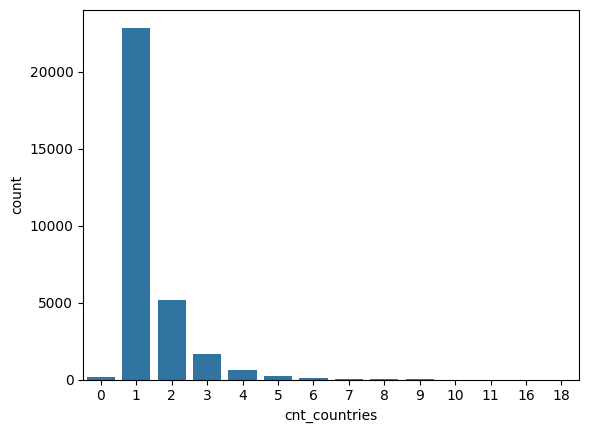

In [257]:
sns.countplot(data=df_films, x="cnt_countries")

In [260]:
df_countries = pd.merge(df_films["country"].explode().reset_index(), df_films.reset_index(), on="index", how="left")
df_countries = df_countries.drop(columns=["country_y"])
df_countries = df_countries.rename(columns={"country_x": "country"})
df_countries.head()

,index,country,name,year,description,1,2,3,4,5,6,7,8,9,10,...,tagline,duration,actors,director,writer,producer,cinematography,composer,studio,genres,themes,link,decade,cnt_genres,cnt_countries
0,2481,USA,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...","[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1
1,15396,Canada,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,...,None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5,2
2,15396,USA,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,...,None,89.0,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5,2
3,32795,Switzerland,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,...,None,90.0,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3,4
4,32795,Turkey,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,...,None,90.0,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3,4


In [261]:
df_countries["country"].nunique()

168

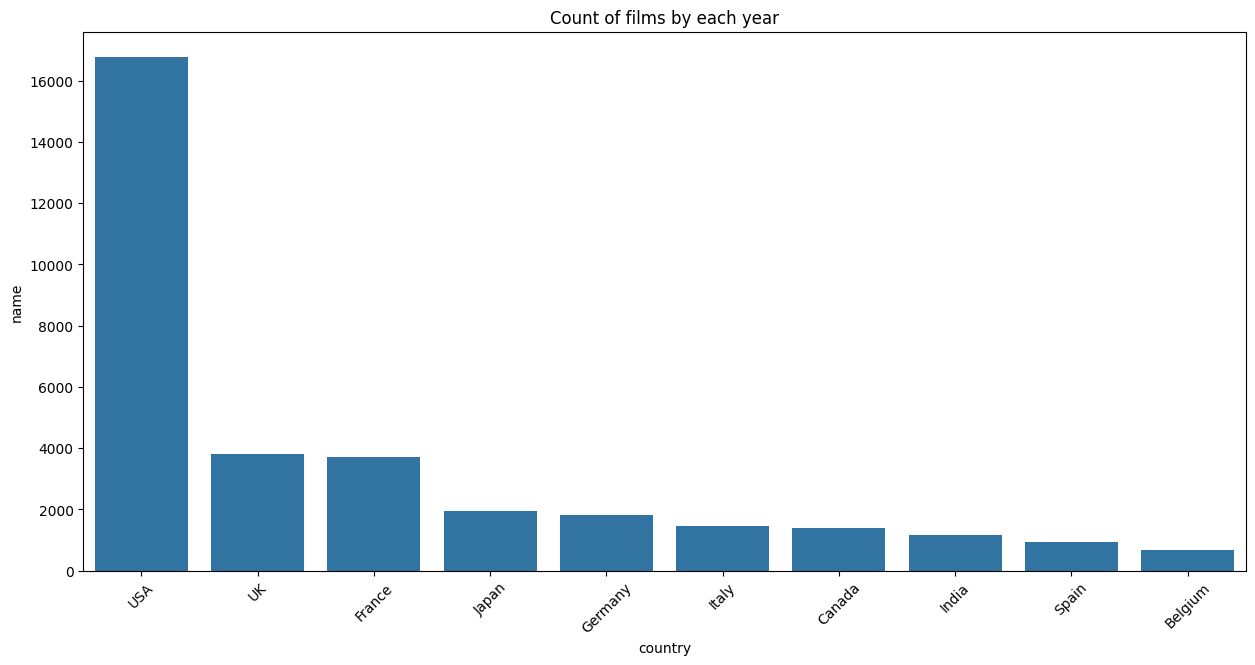

In [266]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_countries.groupby("country")["name"].count().reset_index().sort_values(by="name", ascending=False).head(10), 
    x="country", y="name"
)
plt.xticks(rotation=45)
plt.title("Top 10 countries on count of films")
plt.show()



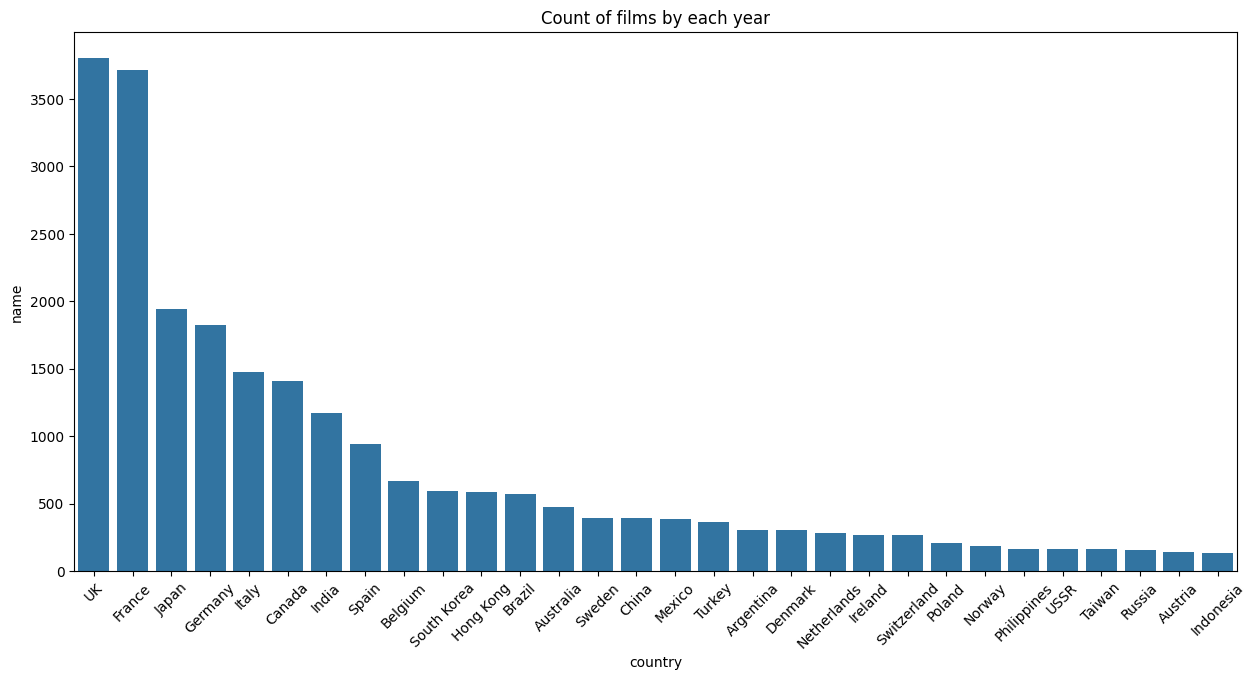

In [267]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_countries.groupby("country")["name"].count().reset_index().sort_values(by="name", ascending=False).iloc[1:31], 
    x="country", y="name"
)
plt.xticks(rotation=45)
plt.title("Top 30 countries on count of films after USA")
plt.show()


In [270]:
df_countries_agg = df_countries.groupby("country").agg({"watched": "mean", "rating": "mean", "name": "count"}).reset_index()
df_countries_agg.head()

,country,watched,rating,name
0,Afghanistan,5240.000000,7.196000,5
1,Albania,8400.000000,6.526667,8
2,Algeria,14110.526316,7.354737,19
3,Angola,5750.000000,7.075000,2
4,Antarctica,2300.000000,7.420000,1


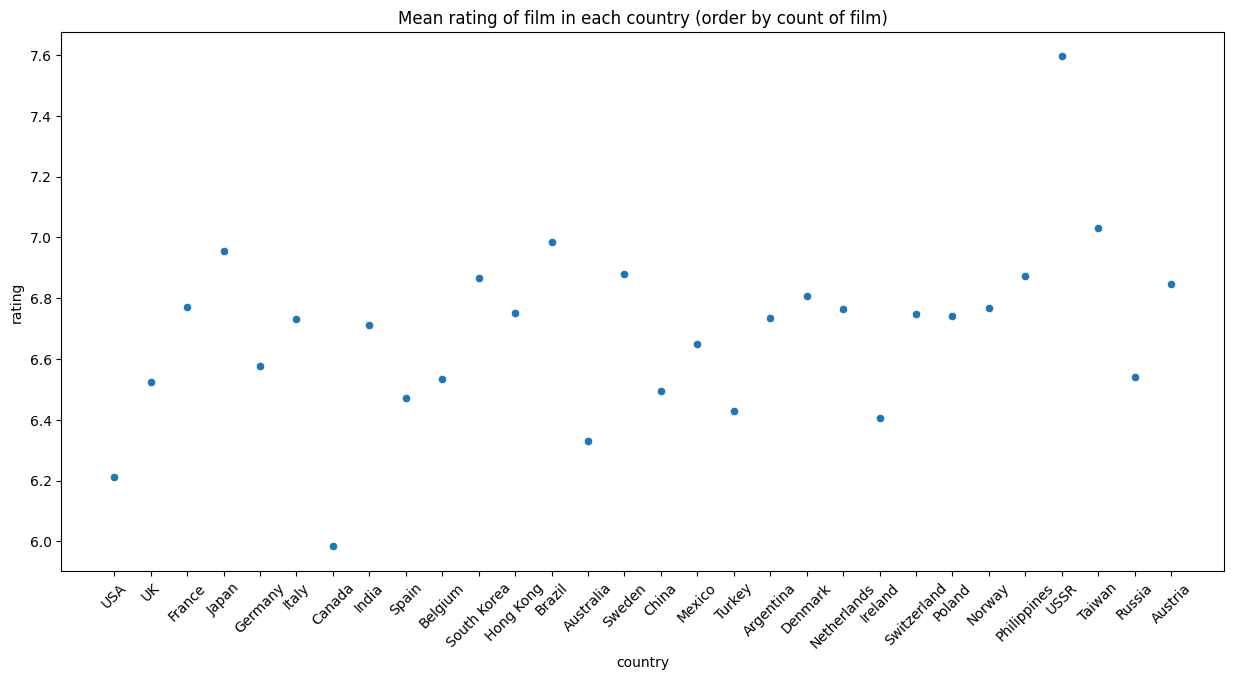

In [276]:
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_countries_agg.sort_values(by="name", ascending=False).head(30), 
    x="country", y="rating"
)
plt.xticks(rotation=45)
plt.title("Mean rating of film in each country (order by count of film)")
plt.show()


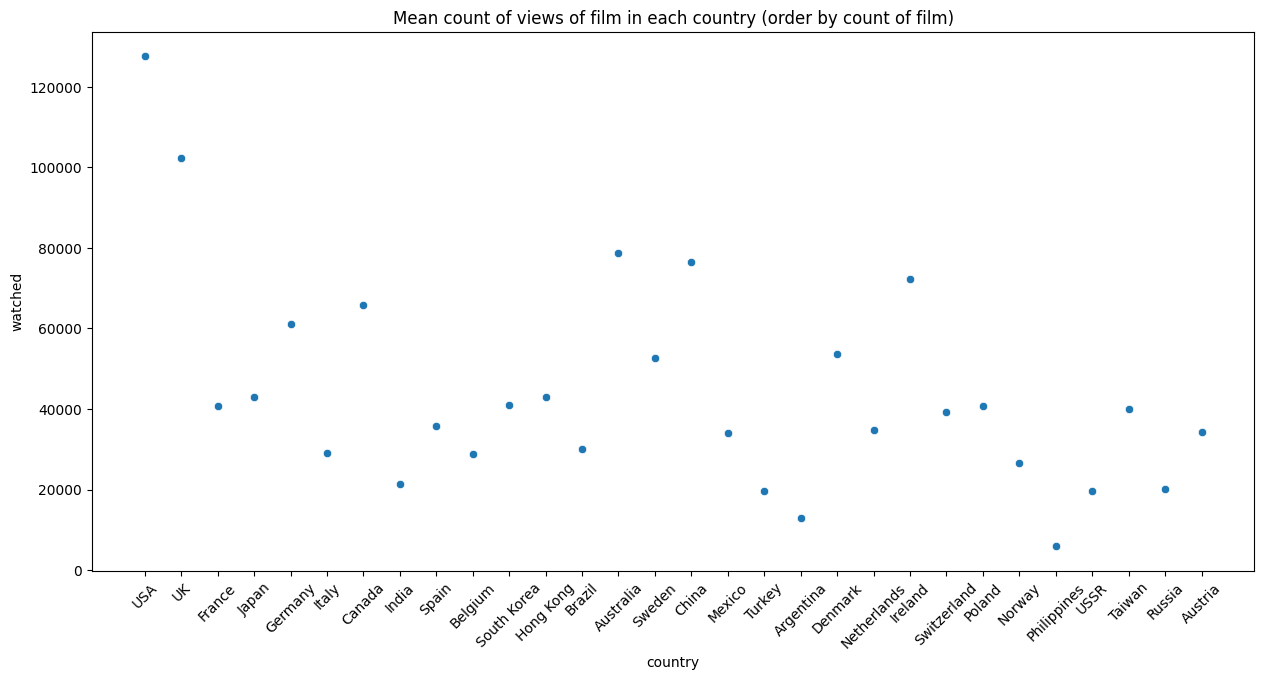

In [277]:
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_countries_agg.sort_values(by="name", ascending=False).head(30), 
    x="country", y="watched"
)
plt.xticks(rotation=45)
plt.title("Mean count of views of film in each country (order by count of film)")
plt.show()


### Studio

In [279]:
cnt_nan_feature(df_films, "studio")

Count of Nan: 0 objects 
0.0% in dataset


In [280]:
cnt_empty_list_feature(df_films, "studio")

Count of empty lists: 709 objects 
2.29% in dataset


In [282]:
df_films["cnt_studios"] = df_films.apply(lambda row: len(row["studio"]), axis=1)
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,actors,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade,cnt_genres,cnt_countries,cnt_studios
2481,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,6.22,160000.0,...,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5
15396,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,5.55,20000.0,...,"[Taylor Handley, Corinne Bohrer, Caitlin Wachs...",Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5,2,2
32795,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,7.47,3800.0,...,"[İlyas Salman, Valérie Lemoine, Micky Sébastia...",Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Switzerland, Turkey, France, Germany]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3,4,3
19980,Love & Human Remains,1993,"In a Canadian metropolis, failed actor David s...",7.0,28.0,38.0,151.0,203.0,551.0,556.0,532.0,178.0,289.0,7.00,3500.0,...,"[Thomas Gibson, Ruth Marshall, Cameron Bancrof...",Denys Arcand,Brad Fraser,Roger Frappier,Paul Sarossy,John McCarthy,"[Atlantis Films, First Choice Films, The Ontar...",[Canada],"[Drama, Comedy]",[],https://letterboxd.com/film/love-human-remains/,1990,2,1,8
28173,Night of the Demons III,1997,When a group of rambunctious teens take refuge...,65.0,170.0,228.0,578.0,455.0,493.0,132.0,76.0,8.0,49.0,4.76,3200.0,...,"[Larry Day, Amelia Kinkade, Kristen Holden-Rie...",Jim Kaufman,Kevin Tenney,Claudio Castravelli,Walter Bal,Raymond C. Fabi,"[Flanders Productions, Fries/Schultz Film Group]","[Canada, USA]","[Comedy, Horror]","[Horror, the undead and monster classics, Gory...",https://letterboxd.com/film/night-of-the-demon...,1990,2,2,2


<Axes: xlabel='cnt_studios', ylabel='count'>

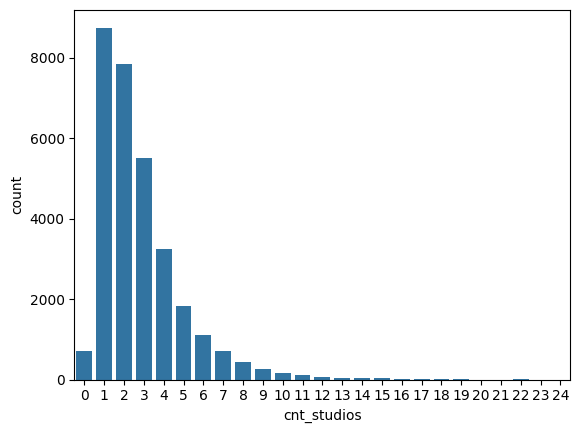

In [283]:
sns.countplot(data=df_films, x="cnt_studios")

In [281]:
df_studios = pd.merge(df_films["studio"].explode().reset_index(), df_films.reset_index(), on="index", how="left")
df_studios = df_studios.drop(columns=["studio_y"])
df_studios = df_studios.rename(columns={"studio_x": "studio"})
df_studios.head()

,index,studio,name,year,description,1,2,3,4,5,6,7,8,9,10,...,tagline,duration,actors,director,writer,producer,cinematography,composer,country,genres,themes,link,decade,cnt_genres,cnt_countries
0,2481,Guerin-Adler-Scott Pictures,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1
1,2481,Bad Hat Harry Productions,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1
2,2481,Jeff Rice Films,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1
3,2481,Casadelic Pictures,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1
4,2481,Terror Films,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,Evil lives within you,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1


In [285]:
df_studios["studio"].nunique()

25686

Count of unique studios almostly equals of count of films in the dataset

In [287]:
df_studios_agg = df_studios.groupby("studio").agg({"watched": "mean", "rating": "mean", "name": "count"}).reset_index()
df_studios_agg.head()

,studio,watched,rating,name
0,"""DIA"" Productions GmbH & Co. KG",16000.0,5.21,1
1,"""Weathering With You"" Film Partners",286000.0,7.37,1
2,(Colossal) Pictures,81000.0,4.68,1
3,(not) HEROINE movies,3200.0,7.44,1
4,(주)라인필름,4800.0,6.67,1


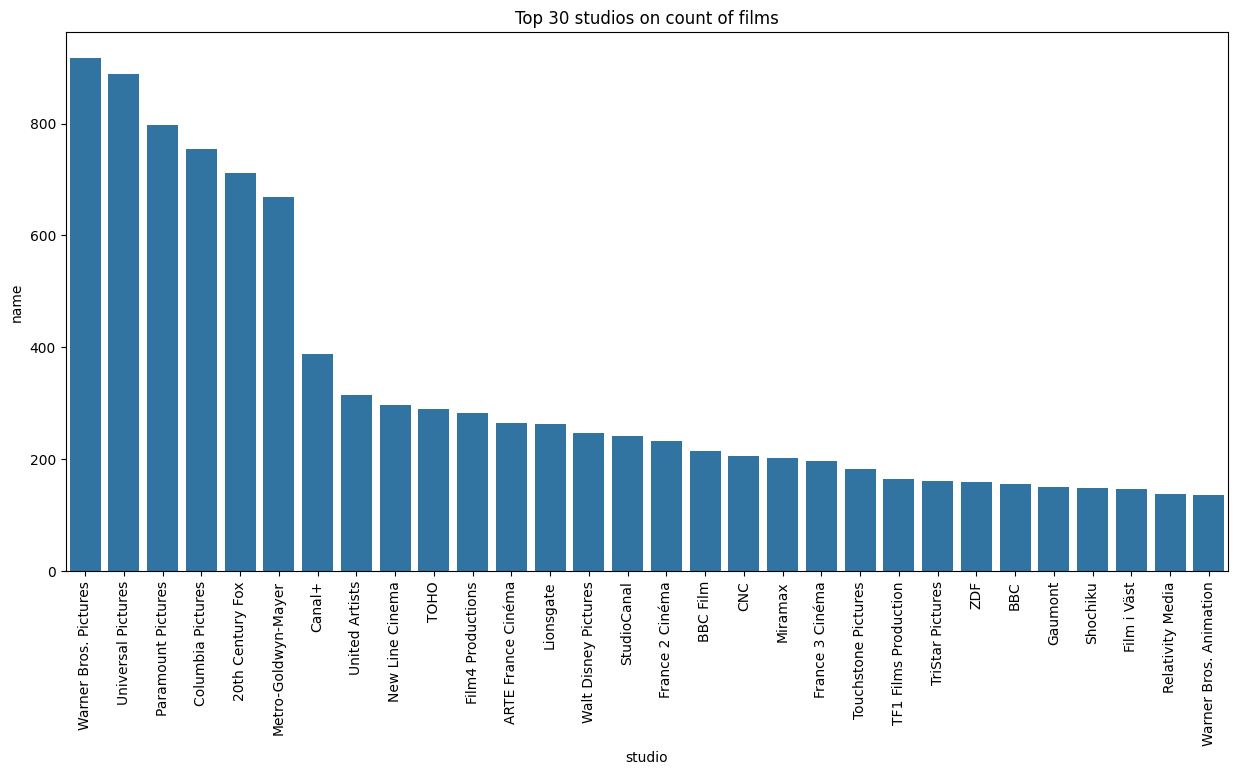

In [296]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_studios_agg.sort_values(by="name", ascending=False).head(30), 
    x="studio", y="name"
)
plt.xticks(rotation=90)
plt.title("Top 30 studios on count of films")
plt.show()



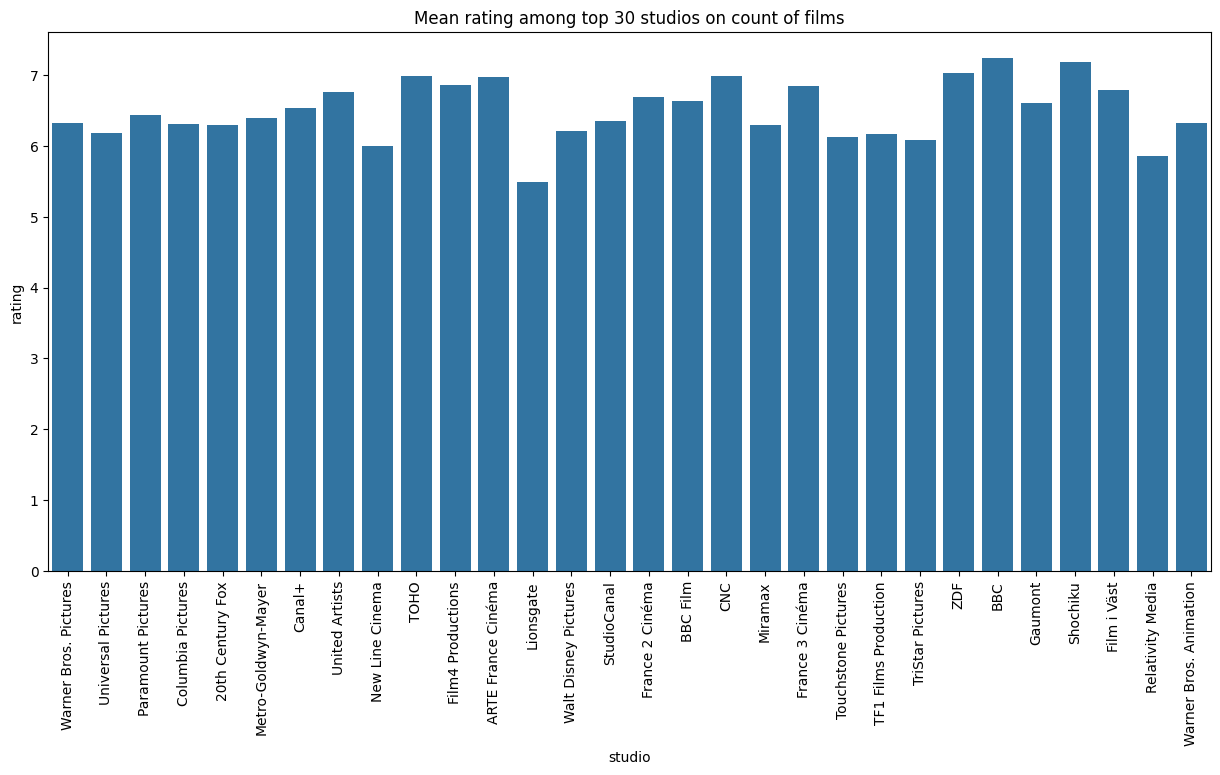

In [297]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_studios_agg.sort_values(by="name", ascending=False).head(30), 
    x="studio", y="rating"
)
plt.xticks(rotation=90)
plt.title("Mean rating among top 30 studios on count of films")
plt.show()


In [300]:
df_studios_agg[df_studios_agg["name"] >= 10].sort_values("rating", ascending=False).head(10)

,studio,watched,rating,name
9867,HYBE,7.945455e+03,9.323636,11
2748,Big Hit Entertainment,9.146154e+03,9.250769,13
15781,National Theatre,2.240769e+04,8.688462,13
9172,Georgia-Film,4.008333e+03,7.919167,12
23150,Tokuma Shoten,6.282312e+05,7.916875,17
24214,VideoFilmes,1.027400e+05,7.863000,20
16884,PBS,2.125000e+04,7.849000,10
8924,GAINAX,6.593636e+04,7.784545,12
1180,American Empirical Pictures,1.139083e+06,7.772500,12
21925,Syncopy,2.678091e+06,7.767273,11


In [302]:
df_studios_agg[df_studios_agg["name"] >= 25].sort_values("rating", ascending=False).head(10)

,studio,watched,rating,name
21624,Studio Ghibli,700721.428571,7.760357,29
15340,Mosfilm,31538.567568,7.743026,79
10706,ITVS,10403.846154,7.572308,26
4208,Channel 4 Television,54428.125000,7.567188,33
12918,Lenfilm,8240.909091,7.540455,25
1652,Art Theatre Guild,8567.000000,7.539286,28
12611,La Sept Cinéma,35124.950000,7.421707,45
6892,El Deseo,100196.428571,7.409286,30
17875,Pony Canyon,39863.827586,7.391724,29
8120,Filmové studio Barrandov,12987.340426,7.388936,49


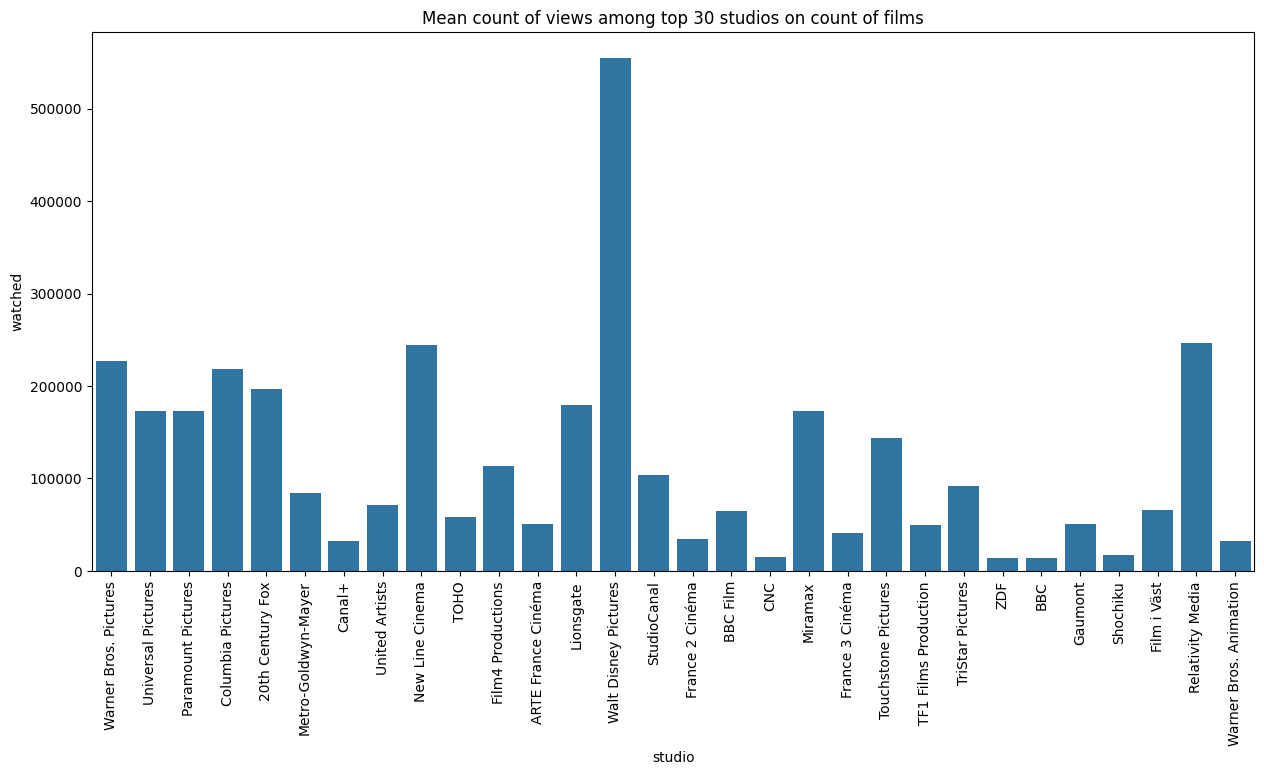

In [298]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_studios_agg.sort_values(by="name", ascending=False).head(30), 
    x="studio", y="watched"
)
plt.xticks(rotation=90)
plt.title("Mean count of views among top 30 studios on count of films")
plt.show()


In [305]:
df_studios_agg[df_studios_agg["name"] >= 25].sort_values("watched", ascending=False).head(10)

,studio,watched,rating,name
17691,Pixar,2.075630e+06,7.305667,30
14434,Marvel Studios,1.833515e+06,6.462391,46
14429,Marvel Entertainment,1.593225e+06,6.227917,25
10221,Heyday Films,1.588852e+06,7.018621,29
6522,DreamWorks Animation,7.535102e+05,6.628367,49
13582,Lucasfilm Ltd.,7.339167e+05,6.736429,42
60,1492 Pictures,7.318600e+05,5.934800,25
12901,Legendary Pictures,7.263683e+05,6.150159,63
21624,Studio Ghibli,7.007214e+05,7.760357,29
1858,Atlas Entertainment,5.940038e+05,5.656154,26


In [304]:
df_studios_agg[df_studios_agg["name"] >= 10].sort_values("watched", ascending=False).head(10)

,studio,watched,rating,name
21925,Syncopy,2.678091e+06,7.767273,11
17691,Pixar,2.075630e+06,7.305667,30
17269,Pascal Pictures,2.063769e+06,7.030000,13
14434,Marvel Studios,1.833515e+06,6.462391,46
14429,Marvel Entertainment,1.593225e+06,6.227917,25
10221,Heyday Films,1.588852e+06,7.018621,29
5660,DC Films,1.431200e+06,5.790000,15
16956,Pacific Data Images,1.314900e+06,6.796000,10
1512,Arad Productions,1.195286e+06,5.690000,14
310,A Band Apart,1.171183e+06,6.805833,12


### Themes

In [306]:
cnt_nan_feature(df_films, "themes")

Count of Nan: 0 objects 
0.0% in dataset


In [307]:
cnt_empty_list_feature(df_films, "themes")

Count of empty lists: 12326 objects 
39.87% in dataset


In [312]:
df_films["cnt_themes"] = df_films.apply(lambda row: len(row["themes"]), axis=1)
df_films.head()

,name,year,description,1,2,3,4,5,6,7,8,9,10,rating,watched,...,director,writer,producer,cinematography,composer,studio,country,genres,themes,link,decade,cnt_genres,cnt_countries,cnt_studios,cnt_themes
2481,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,6.22,160000.0,...,Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]","[Horror, the undead and monster classics, Terr...",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5,6
15396,Phantom of the Megaplex,2000,Pete Riley is a 17-year-old who lands a part-t...,135.0,397.0,481.0,1305.0,1457.0,2294.0,750.0,704.0,102.0,420.0,5.55,20000.0,...,Blair Treu,Stu Krieger,Stu Krieger,Derek Rogers,Bill Elliott,"[Grossbart Barnett Productions, Walt Disney Te...","[Canada, USA]","[Horror, Family, Action, Comedy, Mystery]",[],https://letterboxd.com/film/phantom-of-the-meg...,2000,5,2,2,0
32795,The Yellow Mercedes,1993,"The film is based on ‘Fikrimin Ince Gulu’, a n...",10.0,13.0,8.0,44.0,90.0,339.0,598.0,783.0,196.0,244.0,7.47,3800.0,...,Tunç Okan,Tunç Okan,None,None,None,"[Man Film, Evren Film, L'European]","[Switzerland, Turkey, France, Germany]","[Action, Drama, Comedy]",[],https://letterboxd.com/film/the-yellow-mercedes/,1990,3,4,3,0
19980,Love & Human Remains,1993,"In a Canadian metropolis, failed actor David s...",7.0,28.0,38.0,151.0,203.0,551.0,556.0,532.0,178.0,289.0,7.00,3500.0,...,Denys Arcand,Brad Fraser,Roger Frappier,Paul Sarossy,John McCarthy,"[Atlantis Films, First Choice Films, The Ontar...",[Canada],"[Drama, Comedy]",[],https://letterboxd.com/film/love-human-remains/,1990,2,1,8,0
28173,Night of the Demons III,1997,When a group of rambunctious teens take refuge...,65.0,170.0,228.0,578.0,455.0,493.0,132.0,76.0,8.0,49.0,4.76,3200.0,...,Jim Kaufman,Kevin Tenney,Claudio Castravelli,Walter Bal,Raymond C. Fabi,"[Flanders Productions, Fries/Schultz Film Group]","[Canada, USA]","[Comedy, Horror]","[Horror, the undead and monster classics, Gory...",https://letterboxd.com/film/night-of-the-demon...,1990,2,2,2,6


<Axes: xlabel='cnt_themes', ylabel='count'>

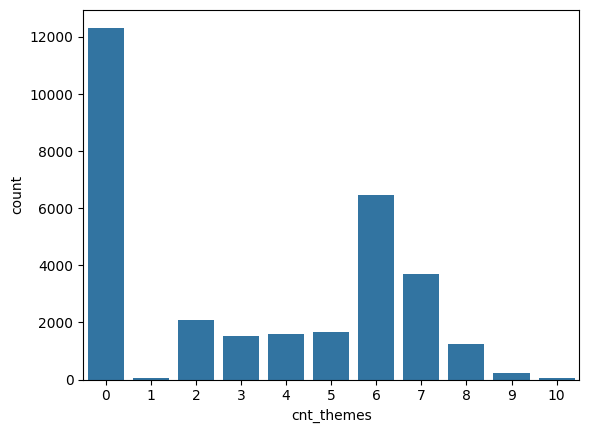

In [313]:
sns.countplot(data=df_films, x="cnt_themes")

In [310]:
df_themes = pd.merge(df_films["themes"].explode().reset_index(), df_films.reset_index(), on="index", how="left")
df_themes = df_themes.drop(columns=["themes_y"])
df_themes = df_themes.rename(columns={"themes_x": "themes"})
df_themes.head()

,index,themes,name,year,description,1,2,3,4,5,6,7,8,9,10,...,duration,actors,director,writer,producer,cinematography,composer,studio,country,genres,link,decade,cnt_genres,cnt_countries,cnt_studios
0,2481,"Horror, the undead and monster classics",The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5
1,2481,"Terrifying, haunted, and supernatural horror",The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5
2,2481,Twisted dark psychological thriller,The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5
3,2481,"Creepy, chilling, and terrifying horror",The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5
4,2481,"Gory, gruesome, and slasher horror",The Taking of Deborah Logan,2014,What starts as a poignant medical documentary ...,1265.0,3022.0,3563.0,11424.0,14532.0,32407.0,22817.0,18743.0,3565.0,5331.0,...,90.0,"[Jill Larson, Anne Ramsay, Michelle Ang, Brett...",Adam Robitel,Adam Robitel,Jeff Rice,Andrew Huebscher,Haim Mazar,"[Guerin-Adler-Scott Pictures, Bad Hat Harry Pr...",[USA],"[Mystery, Horror, Thriller]",https://letterboxd.com/film/the-taking-of-debo...,2010,3,1,5


In [311]:
df_themes["themes"].nunique()

109

In [316]:
df_themes_agg = df_themes.groupby("themes").agg({"watched": "mean", "rating": "mean", "name": "count"}).reset_index()
df_themes_agg.head()

,themes,watched,rating,name
0,Action comedy and silly heroics,245175.466143,5.763304,1050
1,Action-packed space and alien sagas,280510.082645,5.805304,629
2,Adorable animals and heartwarming families,355427.805695,6.234121,605
3,Adrenaline-fueled action and fast cars,198514.062500,5.981941,660
4,Air pilot heroism and survival,135751.260504,6.102667,125


In [319]:
df_themes_agg.sort_values(by="name", ascending=False).head(10)

,themes,watched,rating,name
18,Crude humor and satire,190084.890777,6.096667,3387
70,Moving relationship stories,160827.232285,6.886940,3224
55,"Horror, the undead and monster classics",108483.918129,5.728882,2911
100,Twisted dark psychological thriller,129229.515939,5.903704,2655
44,"Gags, jokes, and slapstick humor",152314.201648,6.018594,2623
45,"Gory, gruesome, and slasher horror",95172.916667,5.734802,2465
95,"Terrifying, haunted, and supernatural horror",115022.742162,5.892231,2240
98,Touching and sentimental family stories,138080.393996,6.833706,2169
43,Funny jokes and crude humor,155507.217521,5.952787,2064
65,Laugh-out-loud relationship entanglements,151331.381381,6.088815,2042


In [323]:
df_films[df_films["cnt_themes"] == 0].agg({"rating": "mean", "watched": "mean"})

rating        6.716320
watched    8613.956847
dtype: float64

In [320]:
df_themes_agg.sort_values(by="rating", ascending=False).head(10)

,themes,watched,rating,name
99,Tragic sadness and captivating beauty,91180.069930,7.429825,291
77,Powerful poetic and passionate drama,92776.241135,7.330920,571
56,Humanity and the world around us,306893.734015,7.275829,1594
90,Surreal and thought-provoking visions of life ...,197849.404762,7.195475,853
25,Emotional and captivating fantasy storytelling,542355.156951,7.160989,449
42,"Fascinating, emotional stories and documentaries",80924.802111,7.058059,387
50,Heartbreaking and moving family drama,88637.739726,7.028455,1487
78,Powerful stories of heartbreak and suffering,136291.711518,7.024468,1889
74,"Political drama, patriotism, and war",72137.470167,6.990662,445
27,Emotional life of renowned artists,112017.213115,6.969810,376


In [321]:
df_themes_agg.sort_values(by="watched", ascending=False).head(10)

,themes,watched,rating,name
25,Emotional and captivating fantasy storytelling,542355.156951,7.160989,449
38,Fairy-tale fantasy and enchanted magic,381734.805654,6.362708,576
41,"Fantasy adventure, heroism, and swordplay",375147.643098,6.167189,619
89,Superheroes in action-packed battles with vill...,358207.871486,5.952635,1282
2,Adorable animals and heartwarming families,355427.805695,6.234121,605
31,Epic adventure and breathtaking battles,350864.197531,6.249784,343
64,Kids' animated fun and adventure,335837.986042,5.966000,1018
54,Holiday joy and heartwarming Christmas,329423.076923,6.145140,581
56,Humanity and the world around us,306893.734015,7.275829,1594
32,Epic heroes,303649.876084,6.112808,1675


### Tagline

### Description

### Popular reviews

### Rating

# Users

In [ ]:
DB_PATH = "data/parsed_data.db"

# Подключение к базе
conn = sqlite3.connect(DB_PATH)

# Чтение таблицы Users
df_users = pd.read_sql_query("SELECT * FROM Users", conn)

# Чтение таблицы Ratings
df_ratings = pd.read_sql_query("SELECT * FROM Ratings", conn)

# Закрываем соединение
conn.close()


In [ ]:
USERS_PATH = "data/data_users.json"

In [333]:
df_users = pd.read_json(USERS_PATH)
df_users.head()

,display_name,status,geo,Films,This year,Lists,Following,Followers,favorities,username,In 2024,List,Follower
0,Cole,member,[Indonesia],94.0,8.0,3.0,46.0,50.0,[],phixstark,NaN,NaN,NaN
1,lydia,member,None,1379.0,NaN,14.0,28.0,14.0,"[persona, 3-women, blue-velvet, eyes-without-a...",sendsweetdreams,NaN,NaN,NaN
2,Andrew,member,[United KIngdom],1253.0,NaN,NaN,140.0,59.0,"[portrait-of-a-lady-on-fire, phantom-thread, l...",jolls6,47.0,NaN,NaN
3,Author Of Many Atrocities 🧌,member,"[Actual Hell (Dhaka, Bangladesh)]",340.0,4.0,5.0,54.0,32.0,[],dragonicuz_28,NaN,NaN,NaN
4,Natalie,member,"[Halifax, Nova Scotia]",2456.0,NaN,2.0,165.0,120.0,"[the-shining, 10-things-i-hate-about-you, donn...",mamayeen,46.0,NaN,NaN


In [334]:
df_users.describe()

,Films,This year,Lists,Following,Followers,In 2024,List,Follower
count,17962.000000,15180.000000,10678.000000,17960.000000,17896.000000,1147.000000,2056.0,66.0
mean,962.409643,45.757378,20.684023,419.503229,333.366674,26.891020,1.0,1.0
std,1418.682676,498.089977,50.244070,2777.725869,1288.415547,49.933266,0.0,0.0
min,50.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.0,1.0
25%,262.000000,12.000000,4.000000,51.000000,41.000000,3.000000,1.0,1.0
50%,563.000000,27.000000,8.000000,127.000000,107.000000,9.000000,1.0,1.0
75%,1167.750000,54.000000,19.000000,306.000000,276.000000,31.000000,1.0,1.0
max,61115.000000,61112.000000,2064.000000,203890.000000,74584.000000,712.000000,1.0,1.0


# Ratings

In [335]:
df_ratings.head()

,user,liked,film,reviewed,rating
0,minkeneedsmovie,0,smile-2-2024,0,2
1,minkeneedsmovie,1,inside-out-2-2024,0,10
2,minkeneedsmovie,0,back-to-black,0,6
3,minkeneedsmovie,0,young-hearts-2024,0,10
4,minkeneedsmovie,1,bob-marley-one-love,0,5
